# Trabalho de Introdução à Ciência de Dados - Equity in Athletics (Equidade no Atletismo)

## Membros
Cecília Junqueira - 2022094888

Carolina Pilla -2022043299


Felipe Gomide - 2022043213

Lucas Junqueira - 2022043264

## Informações

* Base de dados do Departamentodde Educação dos E.U.A.: o [Equity in Athletics](https://ope.ed.gov/athletics/#/datafile/list) -  2006 à 2021
* A base engloba dados sobre equipes esportivas em faculdades americanas, considerando 43 esportes. Nosso foco é na receita (lucro e gastos) das faculdades e nas proporções de homens e mulheres.st

## Referências
* Best D1 Colleges. Disponível em: &#60;https://www.ncsasports.org/best-colleges/best-division-1-colleges&#62;. Acesso em: 16 ago. 2024.
*

## Setup Inicial

Instalação de biblioteca auxiliar e imports

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
#from adjustText import adjust_text
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Processamento dos Dados

## União dos dados de todos os anos

In [2]:
df = pd.read_excel("https://github.com/FelipeGomide/ICD-EquityInAthletics/raw/master/dados/EADA_2006.xls")
df['YEAR'] = 2006

to_concat = []
to_concat.append(df)
for ano in range(2007, 2012):
    df_aux = pd.read_excel(f"https://github.com/FelipeGomide/ICD-EquityInAthletics/raw/master/dados/EADA_{ano}.xls")
    df_aux['YEAR'] = ano

    to_concat.append(df_aux)

for ano in range(2012, 2022):
    df_aux = pd.read_excel(f"https://github.com/FelipeGomide/ICD-EquityInAthletics/raw/master/dados/EADA_{ano}.xlsx")
    df_aux['YEAR'] = ano

    to_concat.append(df_aux)

df = pd.concat(to_concat)
df

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


unitid          institution_name              addr1_txt  \
0      100654  Alabama A & M University       4900 Meridian St   
1      100654  Alabama A & M University       4900 Meridian St   
2      100654  Alabama A & M University       4900 Meridian St   
3      100654  Alabama A & M University       4900 Meridian St   
4      100654  Alabama A & M University       4900 Meridian St   
...       ...                       ...                    ...   
17639  800001   Simon Fraser University  8888 University Drive   
17640  800001   Simon Fraser University  8888 University Drive   
17641  800001   Simon Fraser University  8888 University Drive   
17642  800001   Simon Fraser University  8888 University Drive   
17643  800001   Simon Fraser University  8888 University Drive   

                          addr2_txt city_txt state_cd zip_text  \
0                               NaN   Normal       AL    35762   
1                               NaN   Normal       AL    35762   
2                               NaN   Normal       AL    35762   
3                               NaN   Normal       AL    35762   
4                               NaN   Normal       AL    35762   
...                             ...      ...      ...      ...   
17639  Burnaby, BC, V5A 1S6, Canada      NaN      NaN      NaN   
17640  Burnaby, BC, V5A 1S6, Canada      NaN      NaN      NaN   
17641  Burnaby, BC, V5A 1S6, Canada      NaN      NaN      NaN   
17642  Burnaby, BC, V5A 1S6, Canada      NaN      NaN      NaN   
17643  Burnaby, BC, V5A 1S6, Canada      NaN      NaN      NaN   

       ClassificationCode             classification_name ClassificationOther  \
0                       2              NCAA Division I-AA                 NaN   
1                       2              NCAA Division I-AA                 NaN   
2                       2              NCAA Division I-AA                 NaN   
3                       2              NCAA Division I-AA                 NaN   
4                       2              NCAA Division I-AA                 NaN   
...                   ...                             ...                 ...   
17639                   4  NCAA Division II with football                 NaN   
17640                   4  NCAA Division II with football                 NaN   
17641                   4  NCAA Division II with football                 NaN   
17642                   4  NCAA Division II with football                 NaN   
17643                   4  NCAA Division II with football                 NaN   

       ...  TOTAL_EXP_MENWOMEN  EXP_COED_MEN  EXP_COED_WOMEN  TOTAL_EXP_COED  \
0      ...            185984.0           NaN             NaN             NaN   
1      ...            987673.0           NaN             NaN             NaN   
2      ...           1468708.0           NaN             NaN             NaN   
3      ...             43988.0           NaN             NaN             NaN   
4      ...            460846.0           NaN             NaN             NaN   
...    ...                 ...           ...             ...             ...   
17639  ...            855784.0           NaN             NaN             NaN   
17640  ...            248662.0           NaN             NaN             NaN   
17641  ...            562200.0           NaN             NaN             NaN   
17642  ...            329452.0           NaN             NaN             NaN   
17643  ...            430420.0           NaN             NaN             NaN   

      EXPENSE_MENALL  EXPENSE_WOMENALL  TOTAL_EXPENSE_ALL      Sports  YEAR  \
0             185984                 0             185984    Baseball  2006   
1             543356            444317             987673  Basketball  2006   
2            1468708                 0            1468708    Football  2006   
3              43988                 0              43988        Golf  2006   
4             217410            243436             460846      Soccer  2006   
...          

## Seleção dos atributos de interesse

In [ ]:
#Seleção das colunas de interesse
aux = df[['SUM_PARTIC_MEN', 'SUM_PARTIC_WOMEN', 'Sports', 'YEAR', 'state_cd', 'TOTAL_OPEXP_INCLCOED', "SUM_TOTAL_HDCOACH", "SUM_TOTAL_ASSTCOACH", "TOTAL_REVENUE_ALL", "TOTAL_EXPENSE_ALL"]].reset_index(drop=True)

# Nova coluna, total de participantes
aux['TOTAL_PARTIC'] = aux['SUM_PARTIC_MEN'] + aux['SUM_PARTIC_WOMEN']

aux.shape

In [ ]:
# Modalidades com erro de digitação ou alguma mudança de categorização a partir dos anos
rename = {"Track and Field and Cross Country (combined)": "All Track Combined",
          "Swimming and Diving (combined)": "Swimming and Diving",
          "Field hocky": "Field Hockey"}


# Modalidades que já estão contidas em algum grupo serão removidas
to_drop = ["Track and Field, Indoor", "Track and Field, Outdoor", "Track and Field, X-Country",
           "Track and Field (Indoor)", "Track and Field (Outdoor)", "Swimming",
           "Synchronized Swimming", "Synchronized swimming", "Diving", "Cross Country",
            "Team Handball", "Table Tennis", "Badminton", "Archery", "Weight Lifting", "Rifle", # Esta linha: modalidades com menos de 10 mil atletas todos os anos
           "Other Sports"] # Conjunto de esportes, sem muita informação, possivelmente muito variados

aux = aux.replace(rename)
aux = aux[~aux['Sports'].isin(to_drop)]

In [ ]:
data = aux.groupby(by=['YEAR', 'Sports', 'state_cd']).sum().reset_index()
data.to_csv("tabelas_pre_processadas/modalidades_por_estado.csv", index=False)

Tabelas filtradas para serem usadas no desenvolvimento das análises da **PERGUNTA 2**

In [7]:
df_filtered = df[["YEAR", "institution_name", "state_cd", "SPORTSCODE", "REV_MEN", "REV_WOMEN", "TOTAL_REV_MENWOMEN", "REV_COED_MEN", "REV_COED_WOMEN", "TOTAL_REV_COED", "REVENUE_MENALL", "REVENUE_WOMENALL", "TOTAL_REVENUE_ALL", "EXP_MEN", "EXP_WOMEN", "EFFemaleCount", "EFMaleCount"]]
df_filtered.drop(df_filtered[df_filtered["state_cd"].isnull() == True].index, inplace=True)
df_filtered = df_filtered.groupby(["YEAR", "state_cd", "SPORTSCODE"], as_index = False)[["REV_MEN", "REV_WOMEN", "EXP_MEN", "EXP_WOMEN", "EFFemaleCount", "EFMaleCount"]].sum()

df_filtered["LUCRO_MEN"] = df_filtered["REV_MEN"] - df_filtered["EXP_MEN"]
df_filtered["LUCRO_WOMEN"] = df_filtered["REV_WOMEN"] - df_filtered["EXP_WOMEN"]
df_filtered[3:] = df_filtered[3:].fillna(0)

#df_filtered.to_csv("tabelas_pre_processadas/lucro_participacao.csv", index=False)

<ipython-input-7-47081910294d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(df_filtered[df_filtered["state_cd"].isnull() == True].index, inplace=True)


Essa tabela será adicionada ao GitHub, para evitar o tempo de processamento de todos os dados, durante a realização das análises.

# Pergunta 1: Quais são as modalidades esportivas com maiores investimentos em comissão técnica e contratações?

Após uma análise mais minuciosa do conteúdo das tabelas, percebi que não existe informação suficiente pra quantificar esse tipo de investimento, apenas investimento no geral. Por isso, tive o enfoque nas diferenças de investimento total e no número de participantes de cada modalidade esportiva.

## Importando as tabelas

Tabela processada anteriormente do GitHub e tabela auxiliar com informações geográficas para desenho dos mapas.

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/FelipeGomide/ICD-EquityInAthletics/master/tabelas_pre_processadas/modalidades_por_estado.csv")
data = data.drop(columns = 'Unnamed: 0')

states = geopandas.read_file('https://raw.githubusercontent.com/joncutrer/geopandas-tutorial/master/data/usa-states-census-2014.shp')
states = states[['STUSPS','geometry','NAME']]

states['coords'] = states['geometry'].apply(lambda x: x.representative_point().coords[:])
states['coords'] = [coords[0] for coords in states['coords']]

states = states.drop_duplicates()
states

STUSPS                                           geometry  \
0      CA  MULTIPOLYGON Z (((-118.59397 33.4672 0, -118.4...   
1      DC  POLYGON Z ((-77.11976 38.93434 0, -77.04102 38...   
2      FL  MULTIPOLYGON Z (((-81.81169 24.56874 0, -81.75...   
3      GA  POLYGON Z ((-85.60516 34.98468 0, -85.47434 34...   
4      ID  POLYGON Z ((-117.24303 44.39097 0, -117.21507 ...   
5      IL  POLYGON Z ((-91.50617 40.20064 0, -91.49696 40...   
6      IA  POLYGON Z ((-96.62187 42.77926 0, -96.57794 42...   
7      KY  POLYGON Z ((-89.54443 36.57451 0, -89.47935 36...   
8      LA  POLYGON Z ((-94.04305 32.69303 0, -94.04303 32...   
9      MD  MULTIPOLYGON Z (((-76.04621 38.02553 0, -76.00...   
10     MI  MULTIPOLYGON Z (((-84.61622 45.89447 0, -84.51...   
11     MN  POLYGON Z ((-97.22904 49.00069 0, -96.93096 48...   
12     MO  POLYGON Z ((-95.76564 40.58521 0, -95.53318 40...   
13     NY  MULTIPOLYGON Z (((-72.01893 41.27411 0, -71.92...   
14     OR  POLYGON Z ((-124.55244 42.84057 0, -124.48094 ...   
15     TN  POLYGON Z ((-90.3007 35.02879 0, -90.2653 35.0...   
16     TX  POLYGON Z ((-106.62344 31.91403 0, -106.63011 ...   
17     VA  MULTIPOLYGON Z (((-76.02347 37.28907 0, -75.98...   
18     WI  MULTIPOLYGON Z (((-86.93428 45.42115 0, -86.83...   
19     AZ  POLYGON Z ((-114.79968 32.59362 0, -114.80939 ...   
20     AR  POLYGON Z ((-94.61792 36.49941 0, -94.3612 36....   
21     CO  POLYGON Z ((-109.05996 38.49999 0, -109.05996 ...   
22     IN  POLYGON Z ((-88.05947 37.86669 0, -88.04086 37...   
23     CT  POLYGON Z ((-73.69594 41.11526 0, -73.48271 41...   
24     NE  POLYGON Z ((-104.05314 41.11446 0, -104.05245 ...   
25     NM  POLYGON Z ((-109.0492 31.79655 0, -109.0483 32...   
26     NC  POLYGON Z ((-84.2866 35.20575 0, -84.28322 35....   
27     OH  MULTIPOLYGON Z (((-82.86334 41.69369 0, -82.82...   
28     ME  MULTIPOLYGON Z (((-68.92401 43.88541 0, -68.87...   
29     MA  MULTIPOLYGON Z (((-70.27553 41.31046 0, -70.19...   
30     MS  POLYGON Z ((-91.62136 31.26781 0, -91.56419 31...   
31     MT  POLYGON Z ((-116.04919 49.00091 0, -115.50102 ...   
32     OK  POLYGON Z ((-103.00252 36.67519 0, -103.00196 ...   
33     SC  POLYGON Z ((-83.35324 34.72865 0, -83.32006 34...   
34     SD  POLYGON Z ((-104.0577 44.99743 0, -104.03914 4...   
35     UT  POLYGON Z ((-114.05247 37.60478 0, -114.05247 ...   
36     WA  MULTIPOLYGON Z (((-123.23715 48.68347 0, -123....   
37     WV  POLYGON Z ((-82.59886 38.20101 0, -82.58469 38...   
38     WY  POLYGON Z ((-111.05689 44.86666 0, -111.04428 ...   
39     DE  POLYGON Z ((-75.77379 39.7222 0, -75.75323 39....   
40     RI  MULTIPOLYGON Z (((-71.63147 41.16668 0, -71.59...   
41     AL  POLYGON Z ((-88.46866 31.89386 0, -88.46866 31...   
42     ND  POLYGON Z ((-104.04874 48.99988 0, -103.37547 ...   
43     PA  POLYGON Z ((-80.51989 40.90666 0, -80.51964 40...   
44     VT  POLYGON Z ((-73.41632 44.09942 0, -73.39987 44...   
45     KS  POLYGON Z ((-102.05174 40.00308 0, -101.83216 ...   
46     NV  POLYGON Z ((-120.0048 39.31648 0, -120.00303 3...   
47     NH  POLYGON Z ((-72.55611 42.86625 0, -72.53147 42...   
48     NJ  POLYGON Z ((-75.55945 39.62981 0, -75.53514 39...   

                    NAME                                     coords  
0             California   (-119.99801052849335, 37.28174301887195)  
1   District of Columbia           (-76.99941630322527, 38.8985315)  
2                Florida   (-81.46903023691782, 27.829472655957098)  
3                Georgia           (-83.25208819002944, 32.6942025)  
4                  Idaho           (-115.4690017868439, 45.5079375)  
5               Illinois    (-89.44939889721522, 39.74387361316114)  
6                   Iowa   (-93.14590061258805, 41.956402999999995)  
7               Kentucky           (-84.72303481161494, 37.8226095)  
8              Louisiana           (-91.63935742247855, 30.9831505)  
9               Maryland           (-76.75186368471782, 38.8210155)  
10              Michigan    (-86

## Análise Exploratória: Plotando mapas e gráficos de evolução no tempo

### Geração de Mapas, quantidade de participantes por modalidade

In [ ]:
def plot_modalidade(states, aux, modalidade, ano):

    # Seleciono o ano e esporte de interesse no dataframe
    esporte = aux.loc[aux['Sports'] == f'{modalidade}']
    modal = esporte.loc[esporte['YEAR'] == ano]

    #Agrego os dados de mapas no dataframe
    map = states.merge(modal, left_on='STUSPS', right_on='state_cd', how='left')
    map = map[['geometry', 'TOTAL_PARTIC', 'STUSPS', 'NAME', 'coords']]

    f, ax = plt.subplots()
    f.set_size_inches(14, 12)

    map.plot(
        ax=ax,
        column='TOTAL_PARTIC',
        cmap='Oranges',
        edgecolor="black",
        linewidth=0.4,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "black",
            "label": "Missing values",
        },
    )

    texts = []

    for idx, row in map.iterrows():
        texts.append(ax.text(row.coords[0], row.coords[1], s=row['NAME'], horizontalalignment='center',)) #bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

    sm = plt.cm.ScalarMappable(
        cmap="Oranges",                      # Usa o mesmo cmap do mapa
        norm=plt.Normalize(
            vmin= 0,  # Valor mínimo
            vmax=map["TOTAL_PARTIC"].max(),  # Valor máximo
        ),
    )

    cax = f.add_axes(
        [
            0.9,    # posicao x (entre 0.0 e 1.0)
            0.3,    # posicao y (entre 0.0 e 1.0)
            0.03,    # largura x
            0.40,    # altura y
        ]
    )

    ax.set_title(f'Quantity of Athletes by State, {modalidade} {ano}', fontdict={"fontsize": 16})
    ax.axis('off')

    # A linha abaixo utiliza a biblioteca que otimiza o posicionamento dos textos no plot
    # Melhora bastante a visualização dos nomes, já que evita sobreposição,
    # porém afeta bastante o desempenho
    #adjust_text(texts, time_lim=30, arrowprops=dict(arrowstyle='-', color='black', alpha=1), ax=ax)

    f.colorbar(sm, cax=cax)
    plt.show()

# TO-DO imprimir os gráficos bonitinho contando os resultados

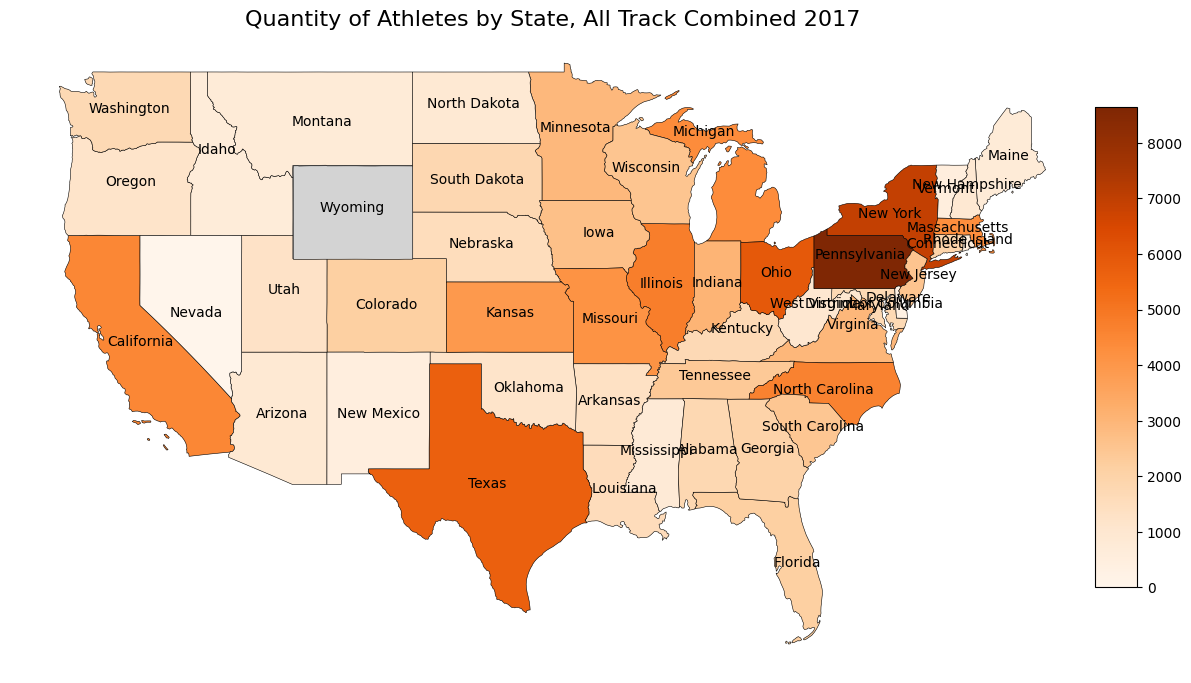

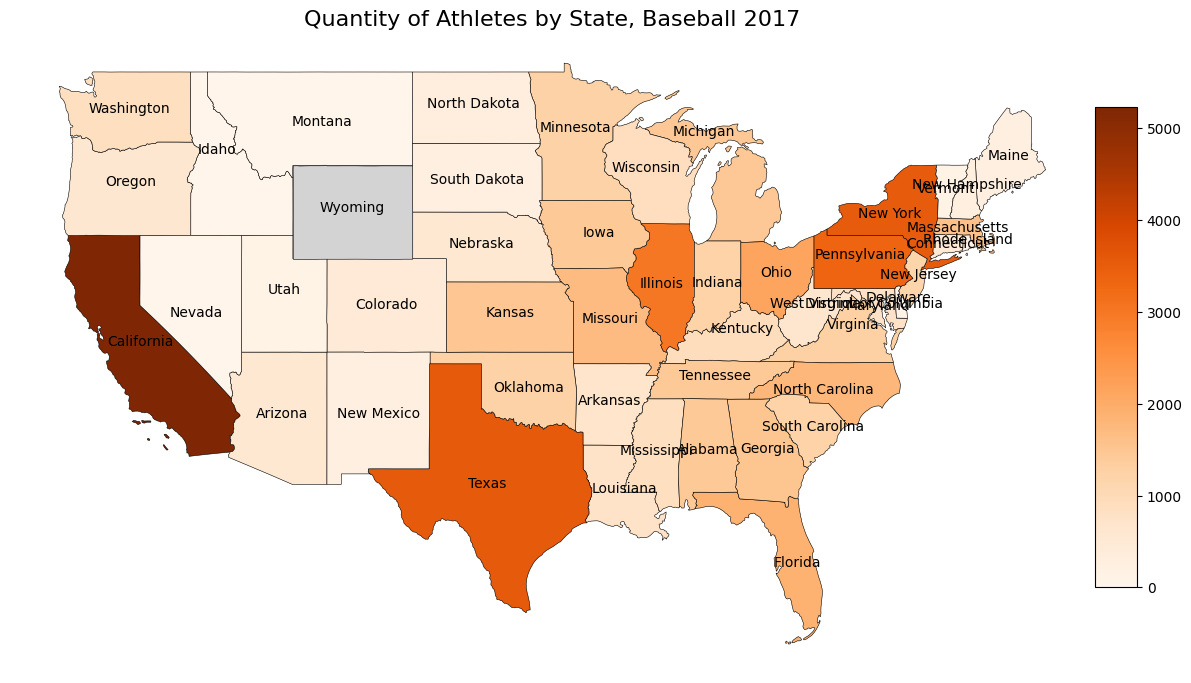

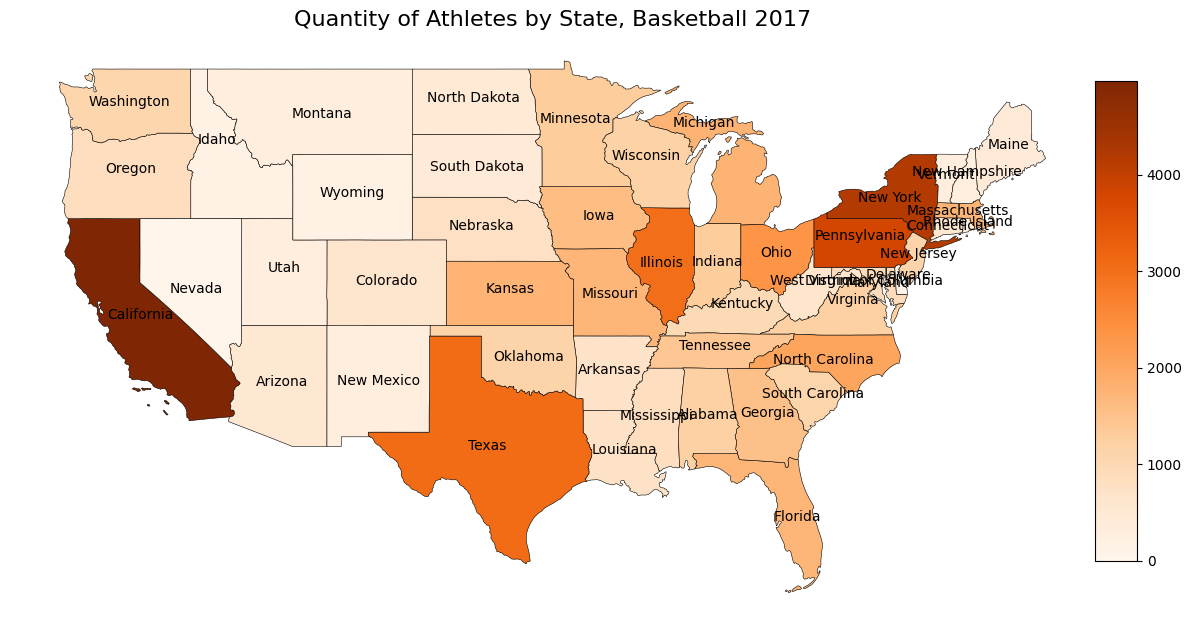

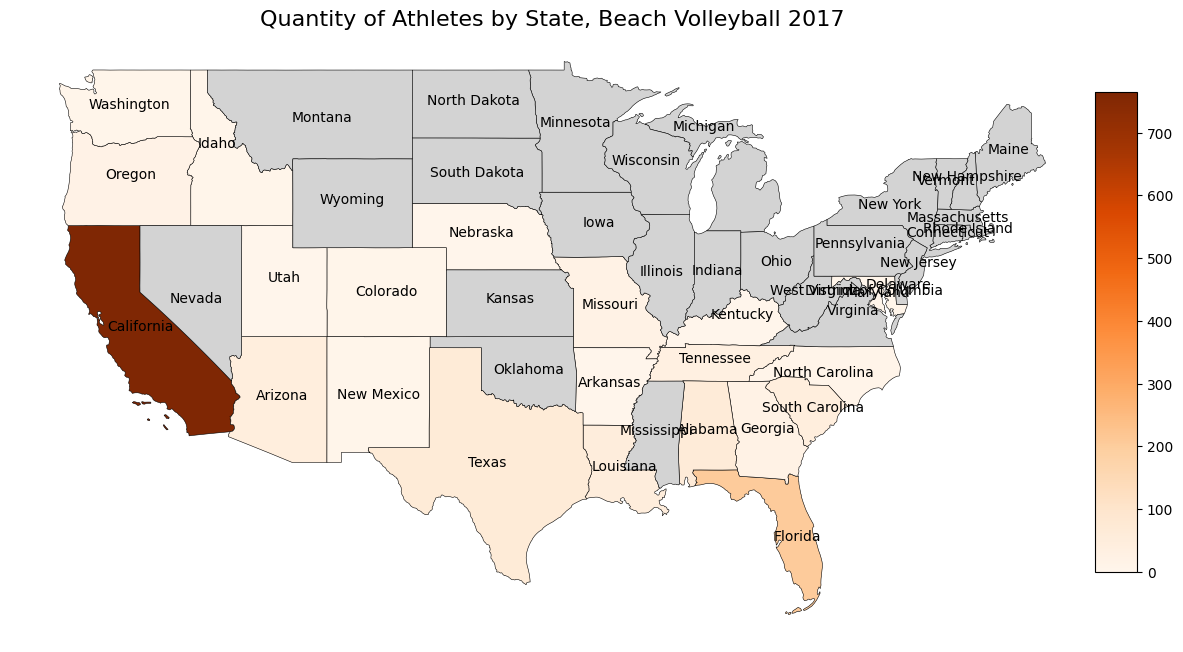

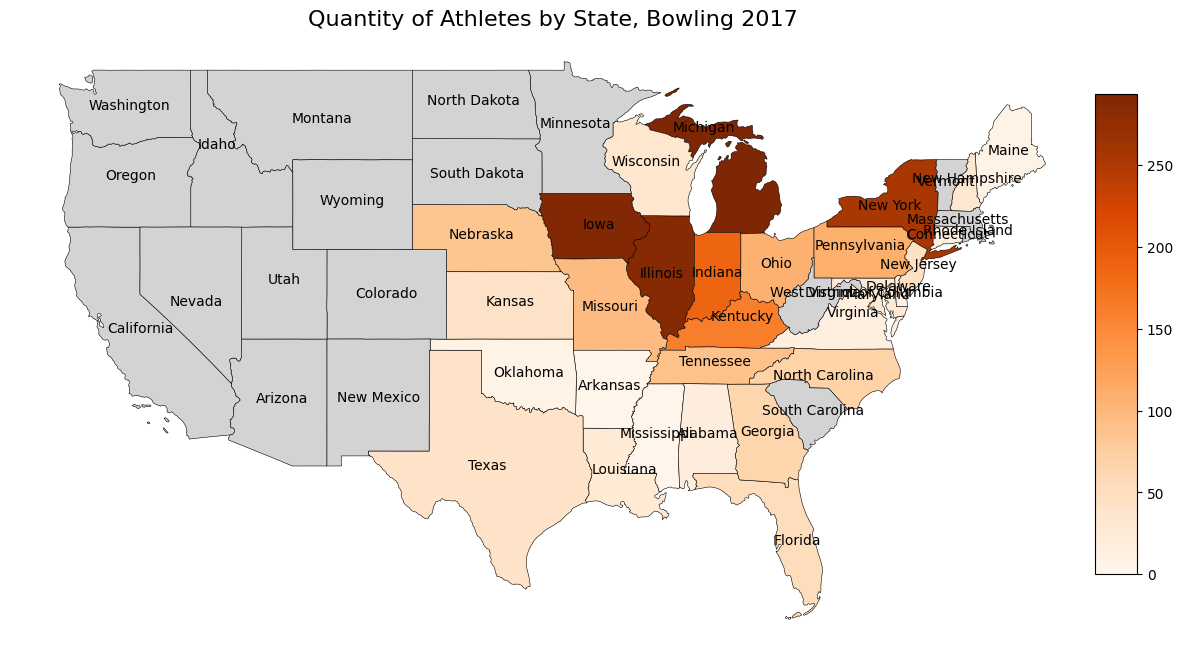

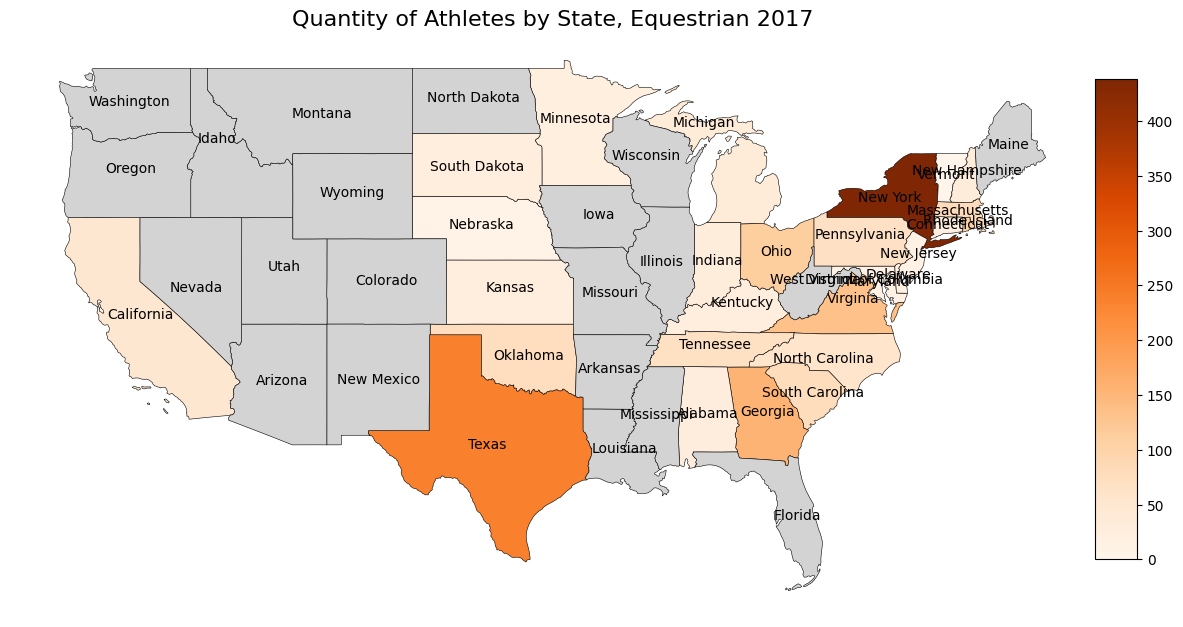

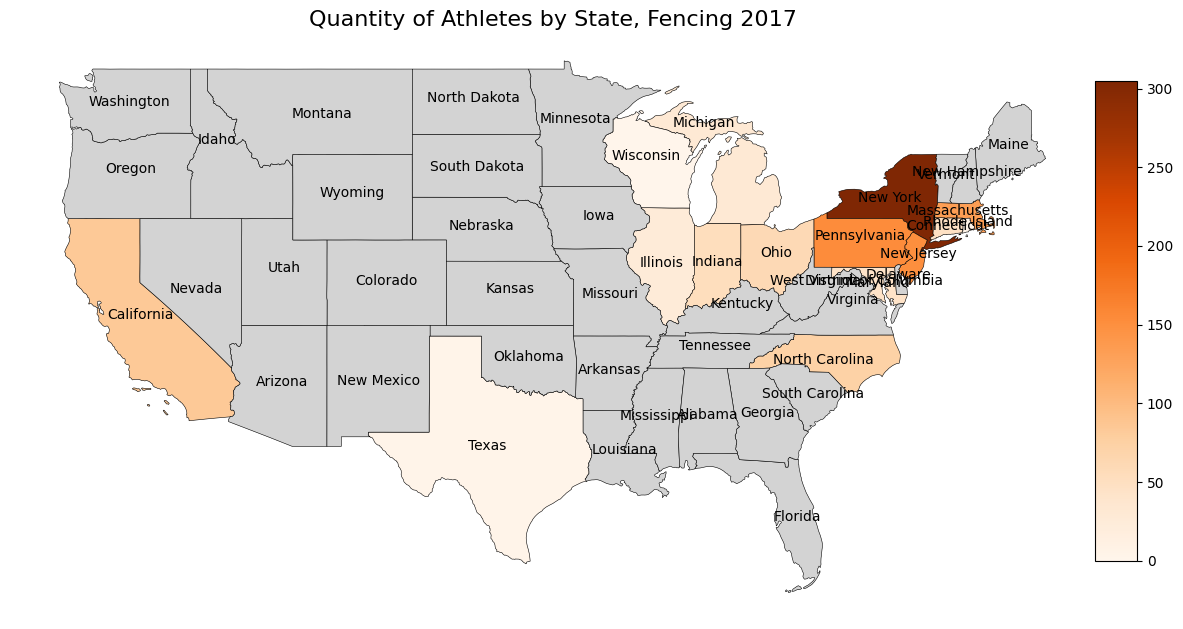

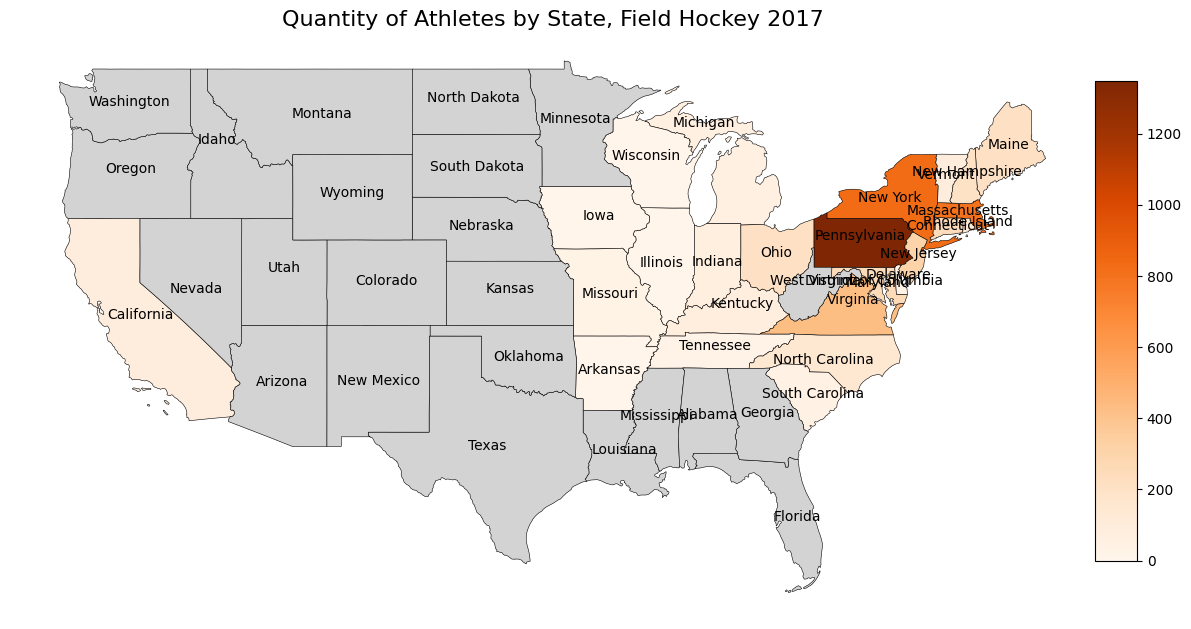

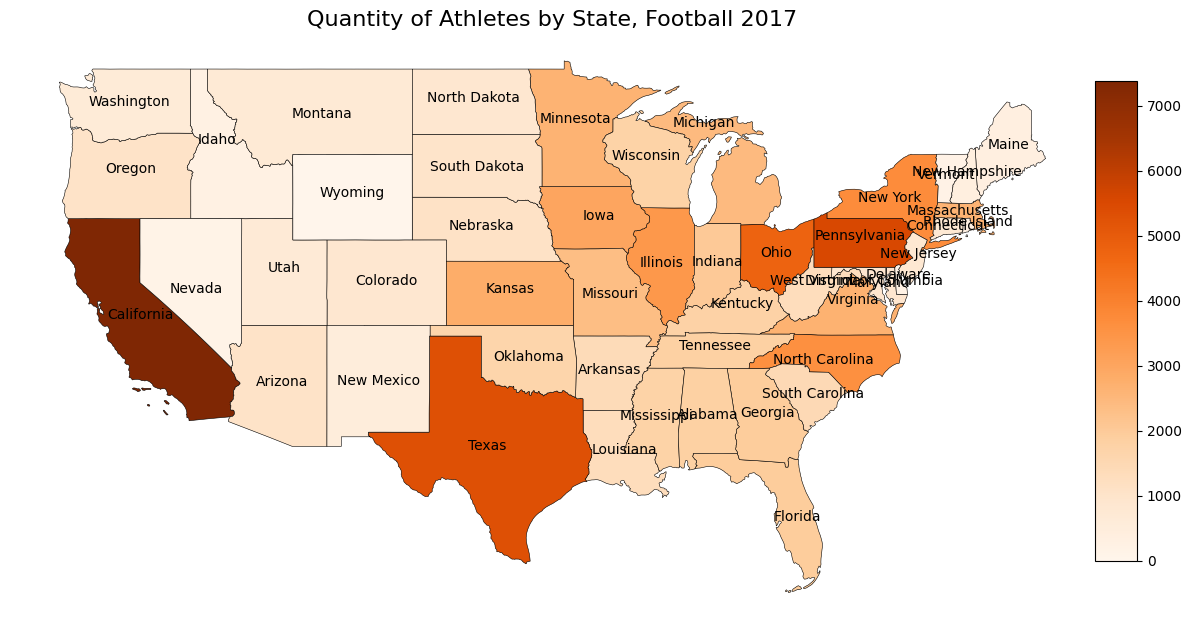

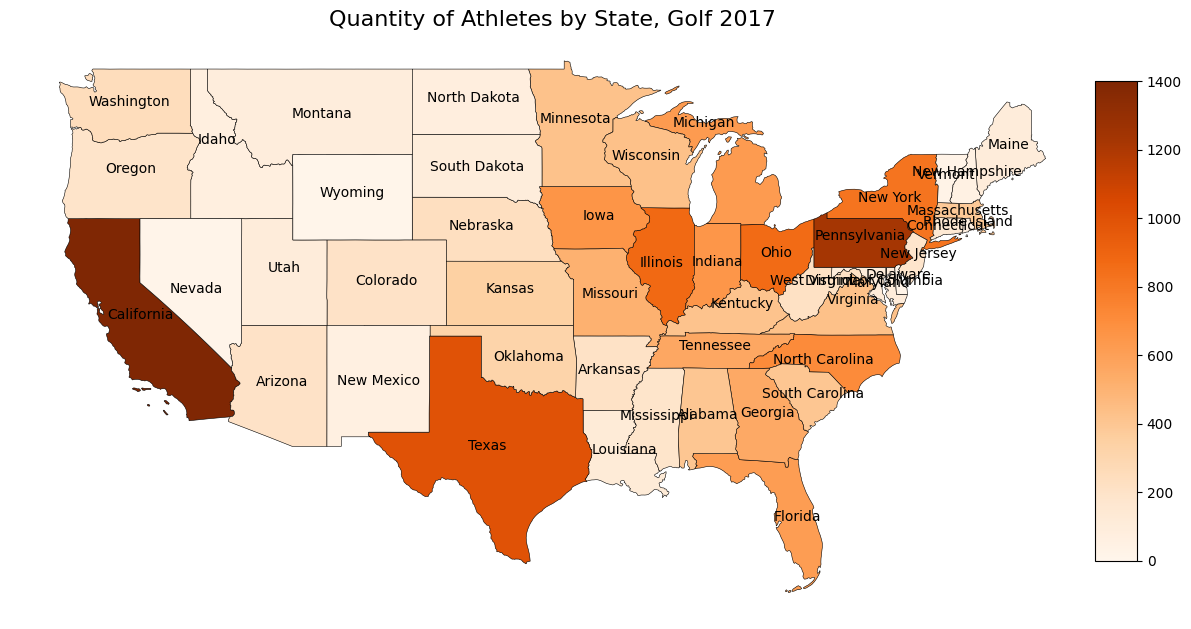

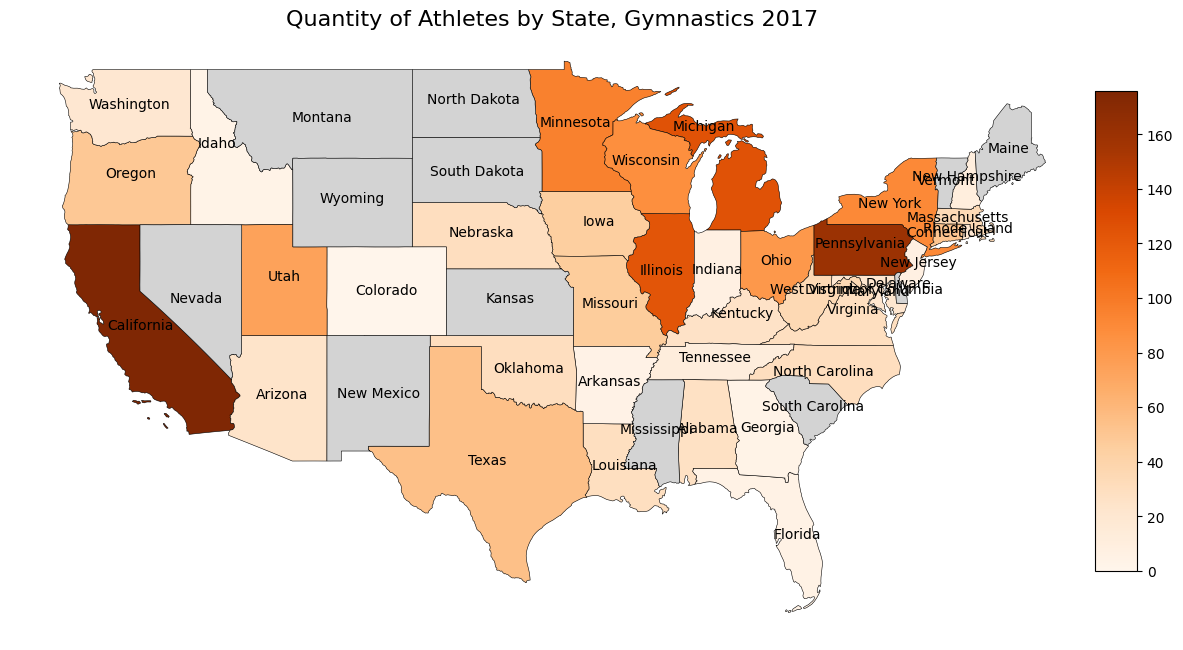

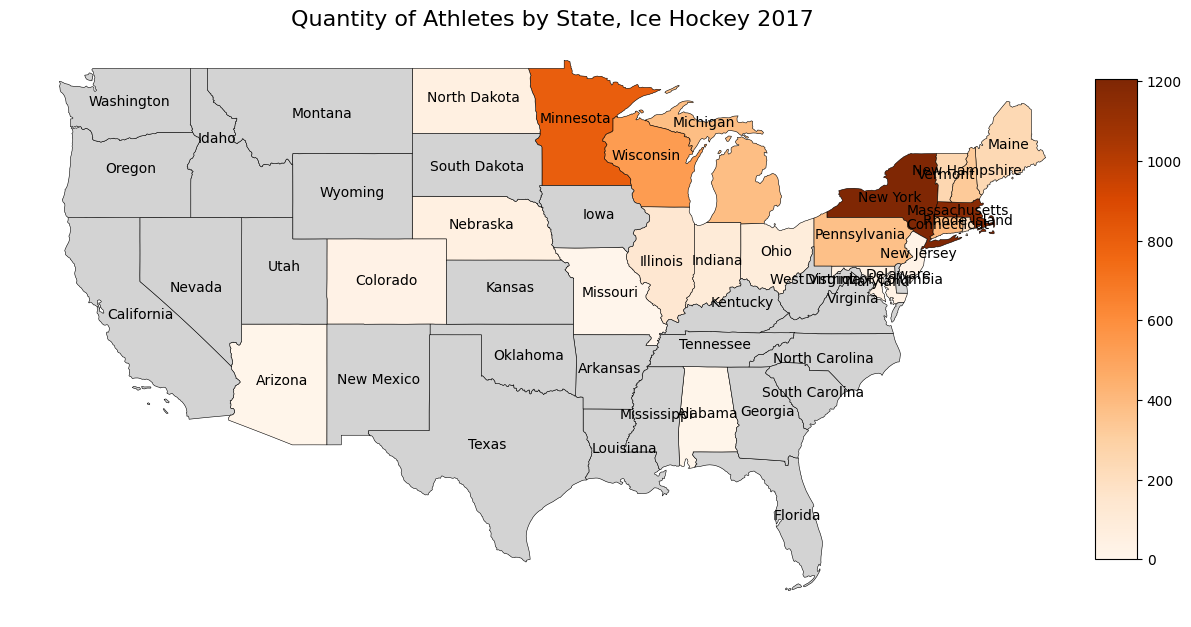

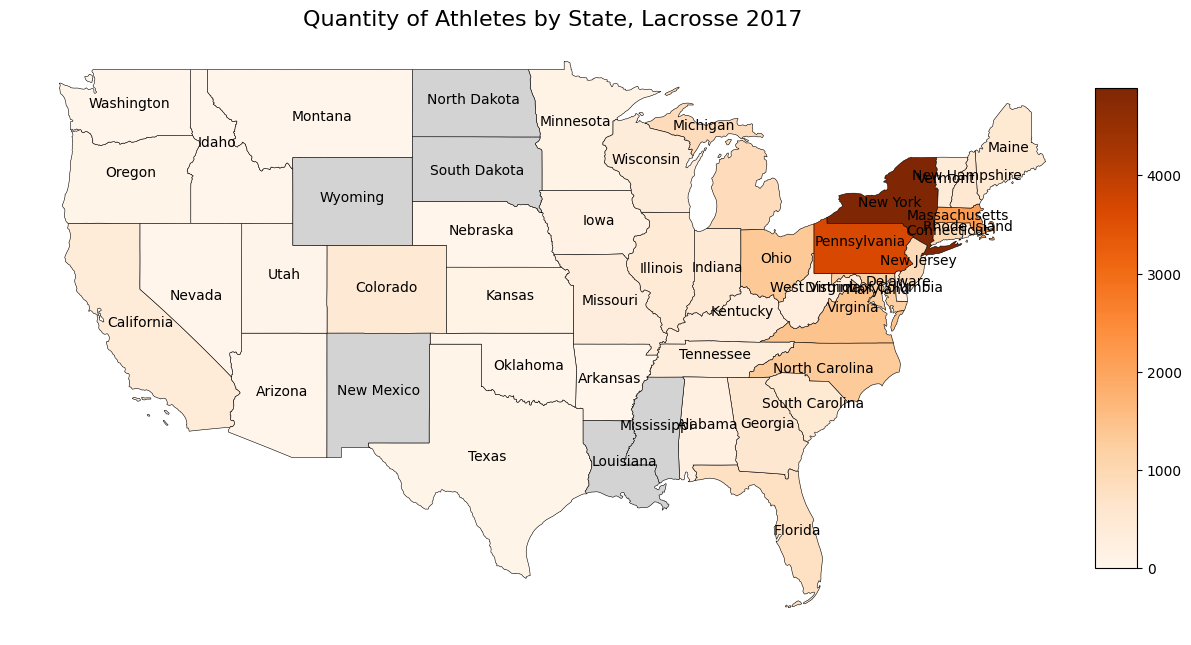

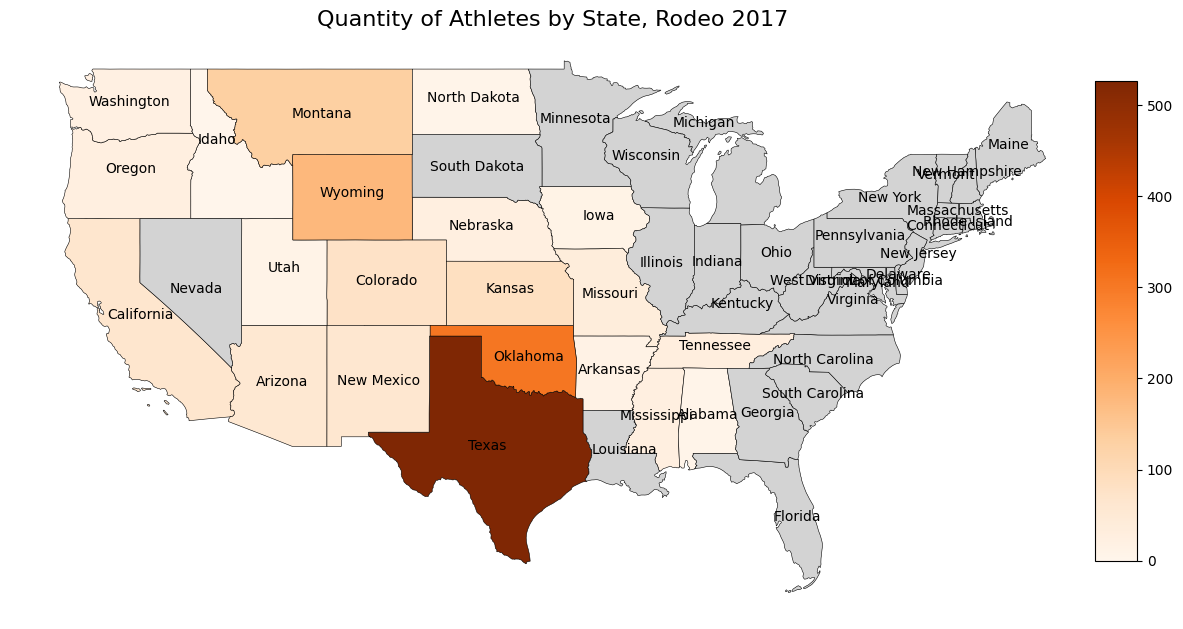

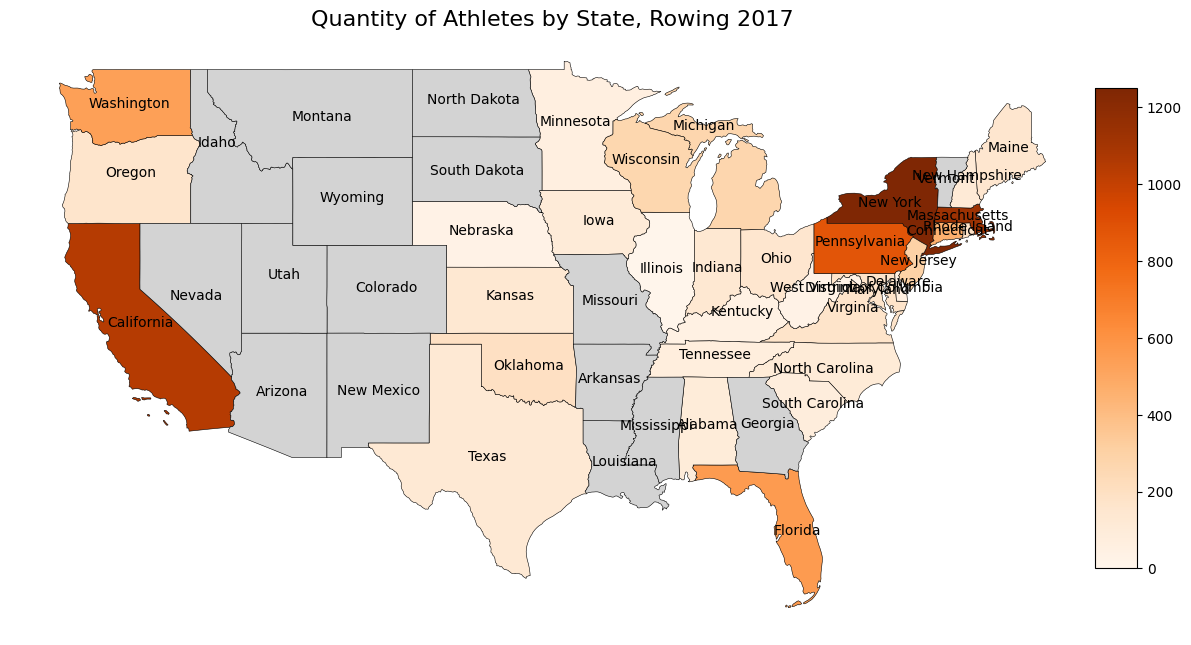

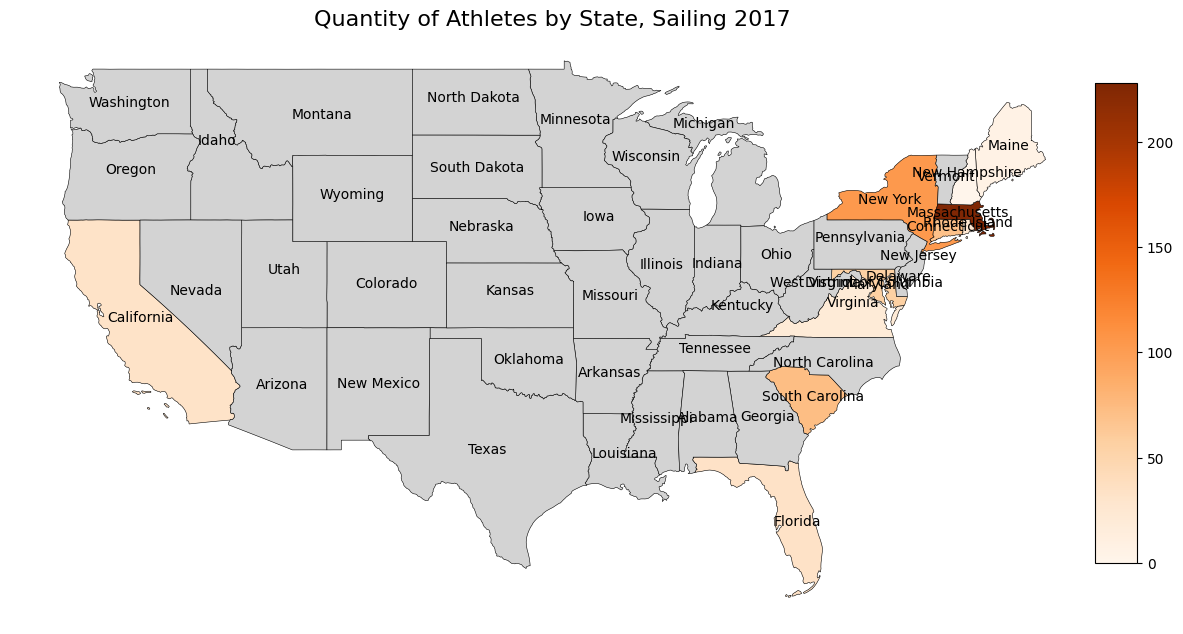

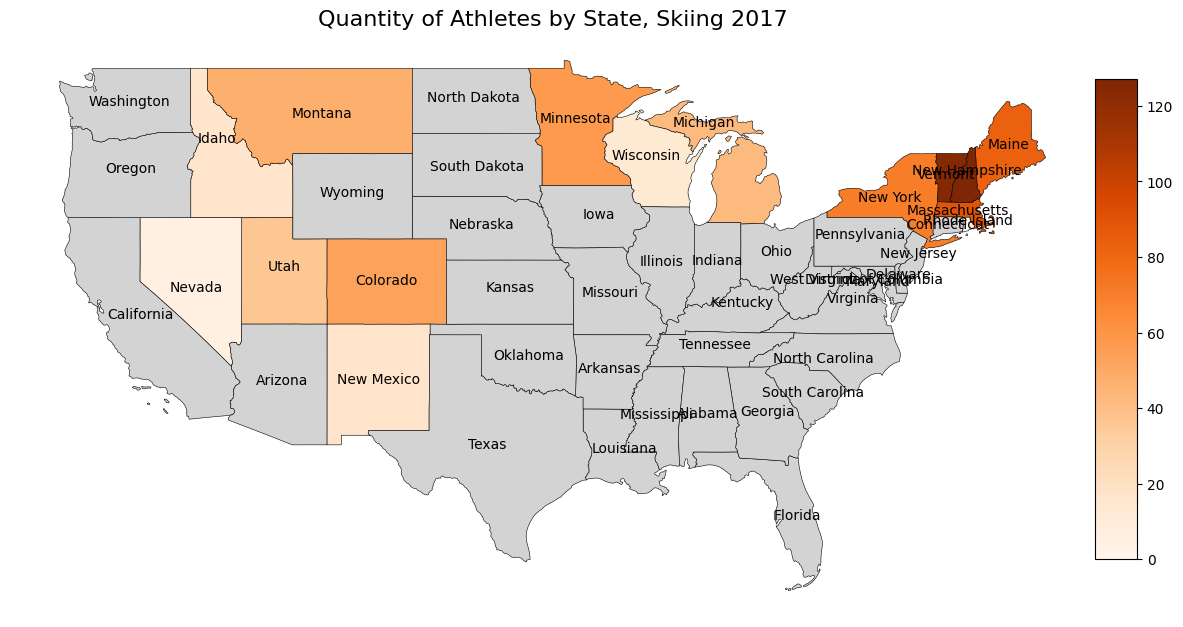

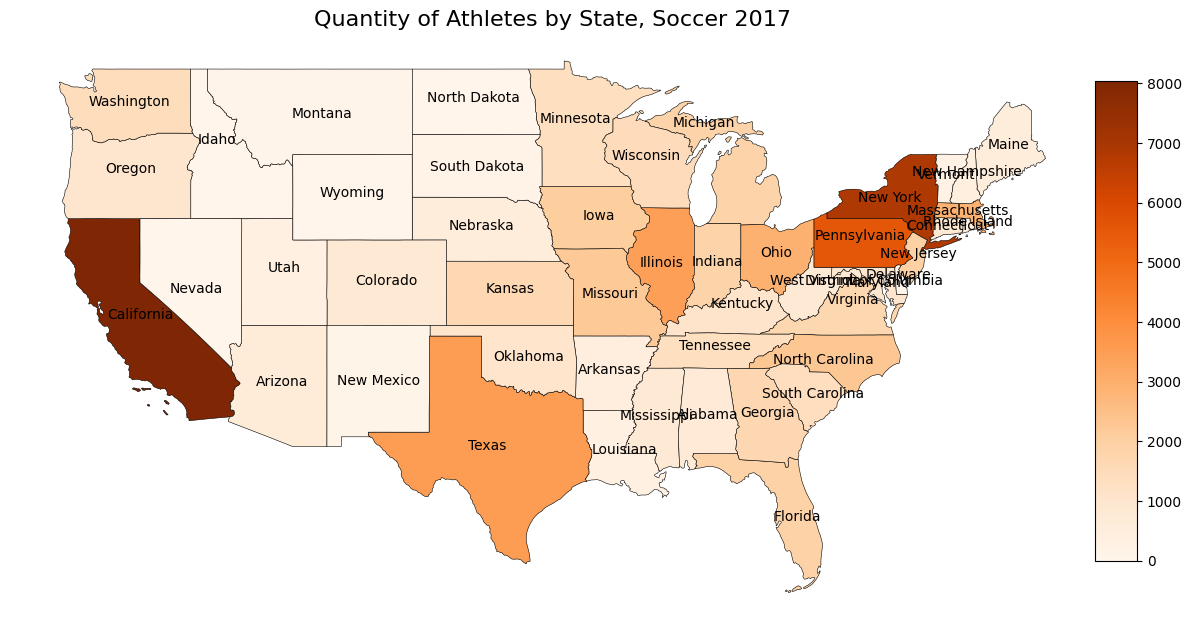

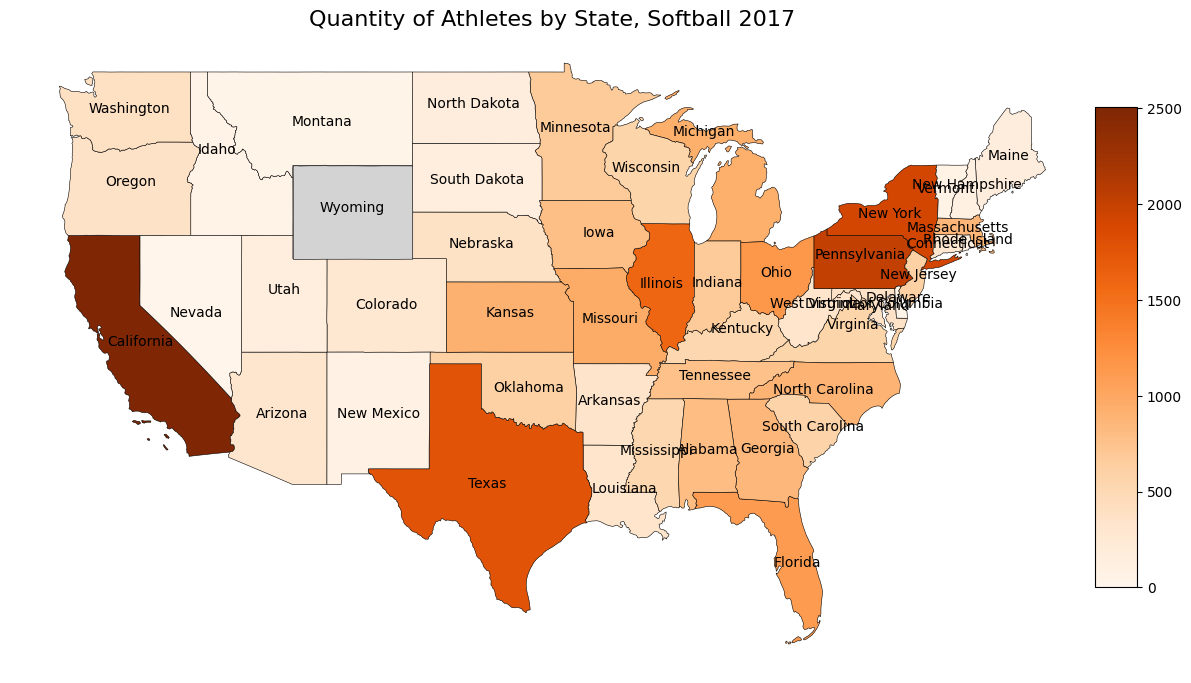

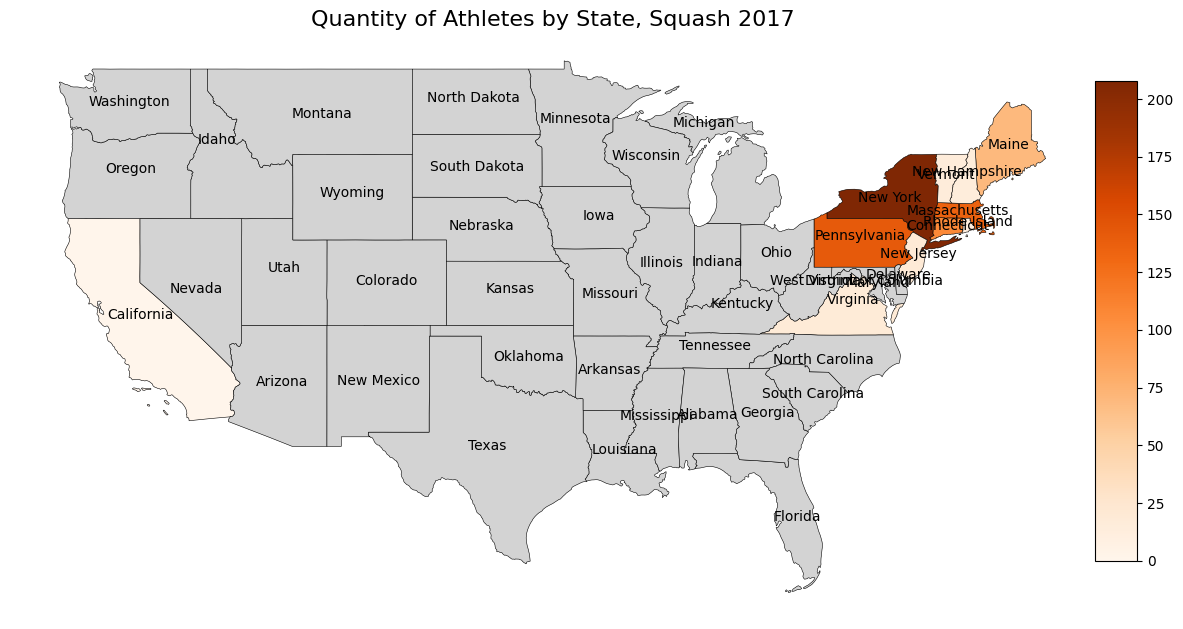

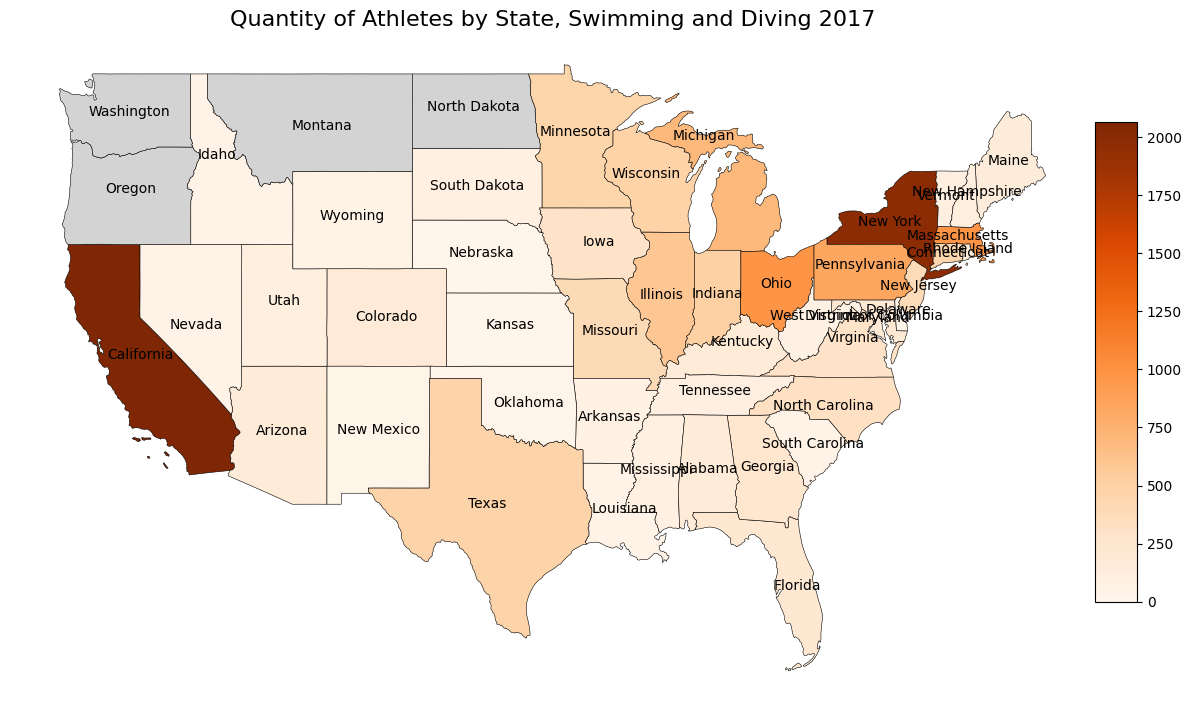

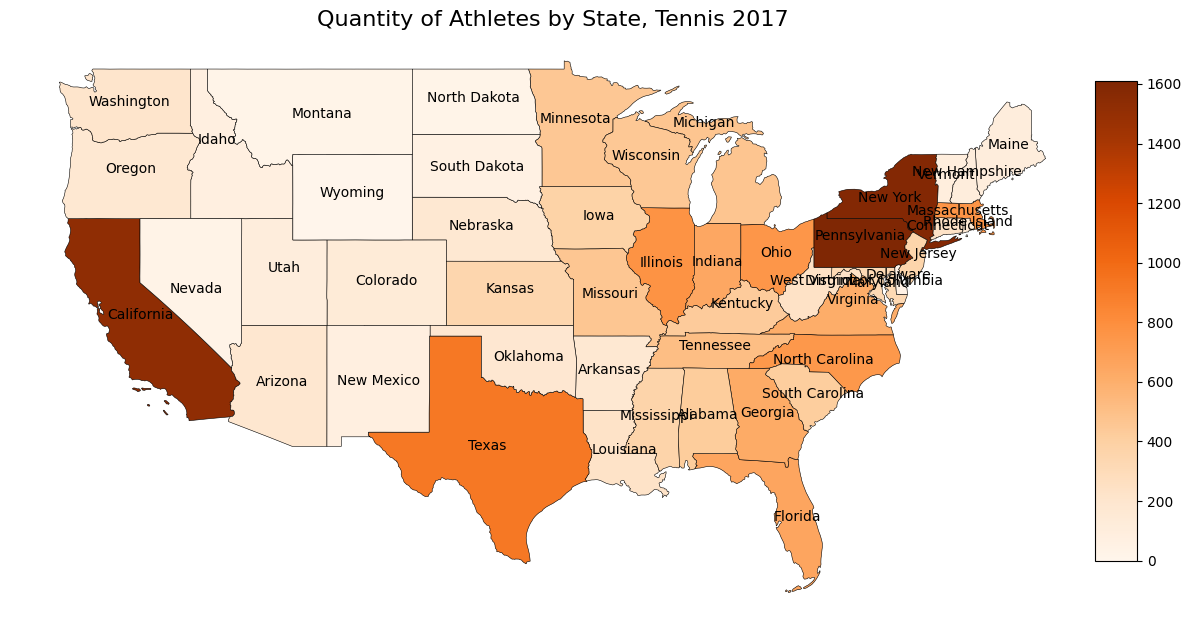

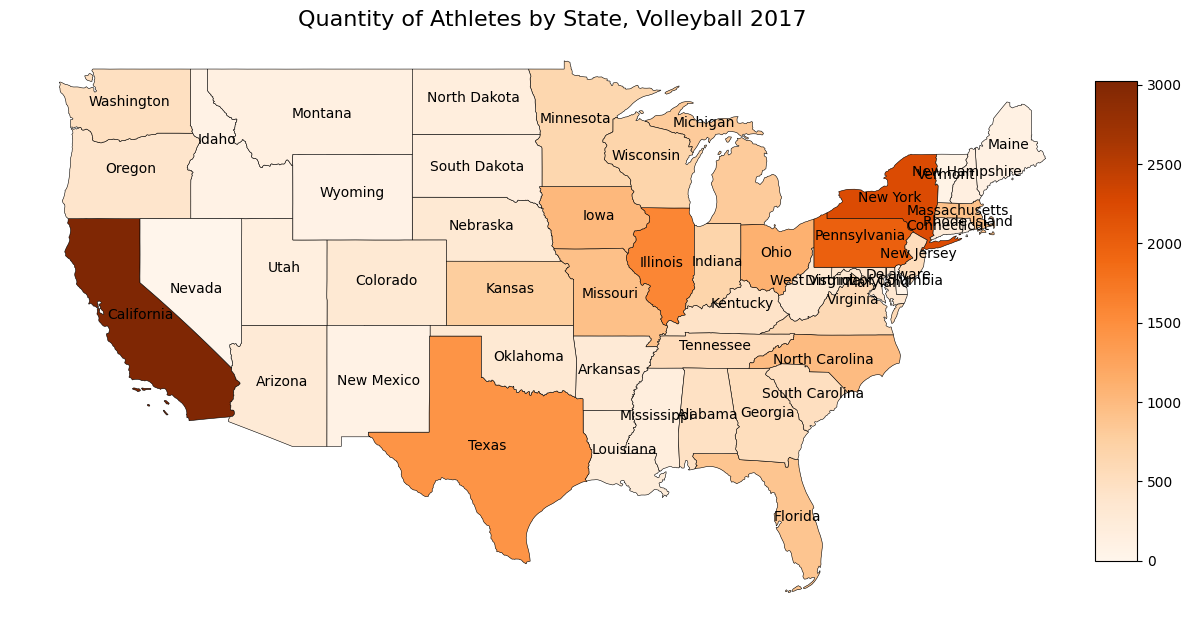

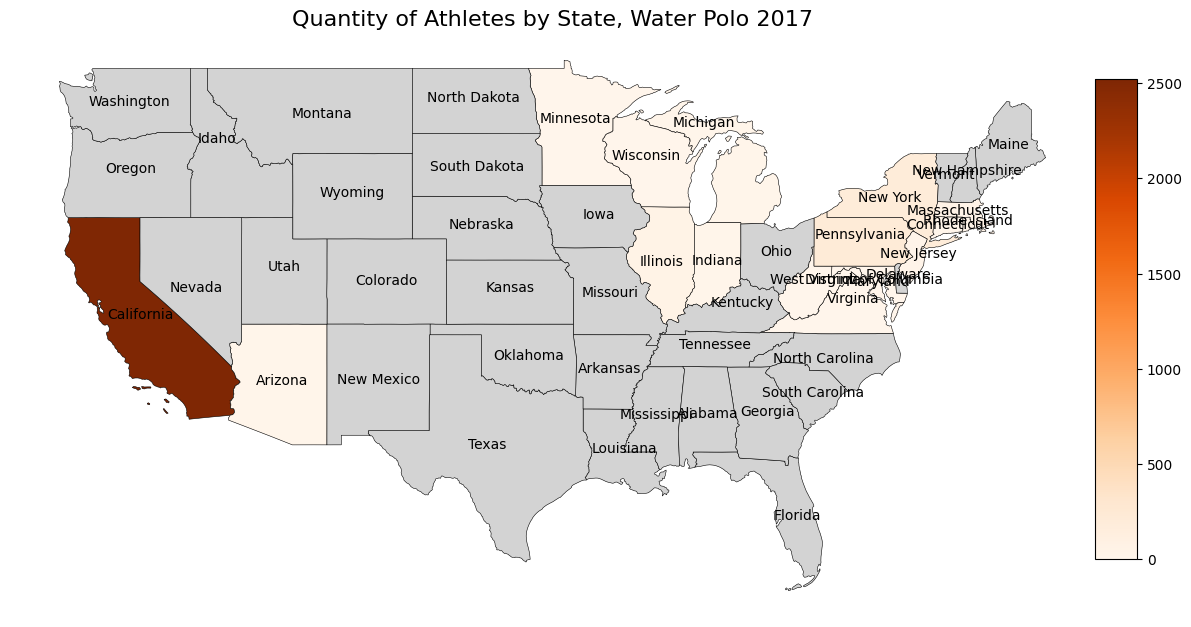

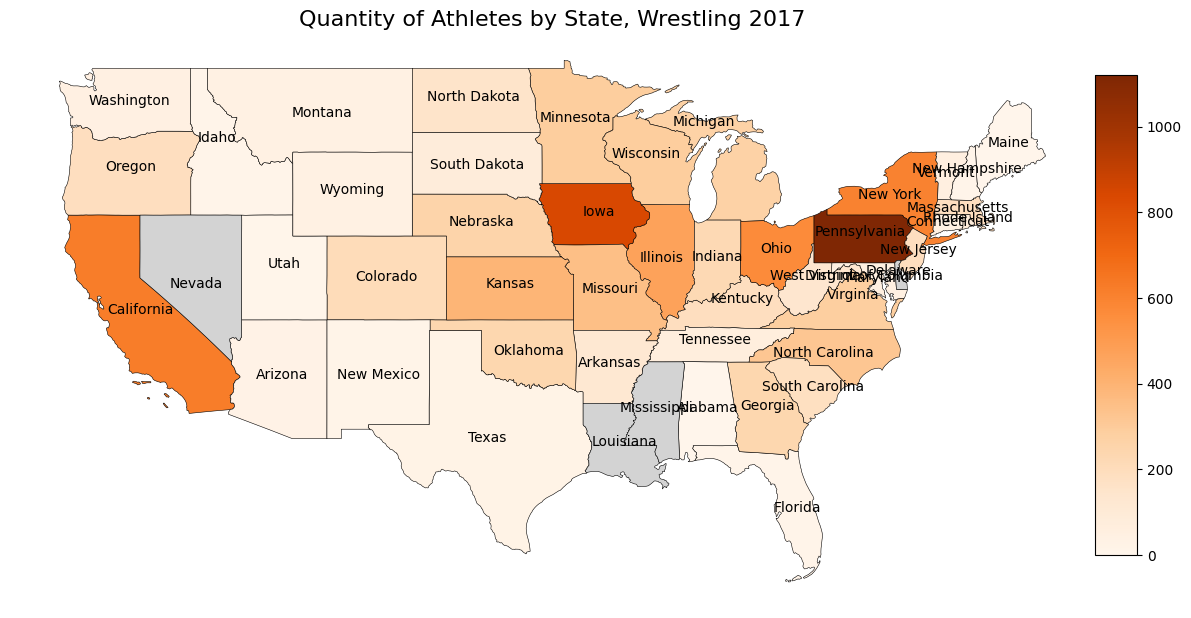

In [ ]:
modalidades = data['Sports'].drop_duplicates().sort_values().reset_index(drop=True)
for sport in modalidades:
    plot_modalidade(states, data, sport, 2017)

### Gráficos de Evolução das Modalidades ao passar do tempo

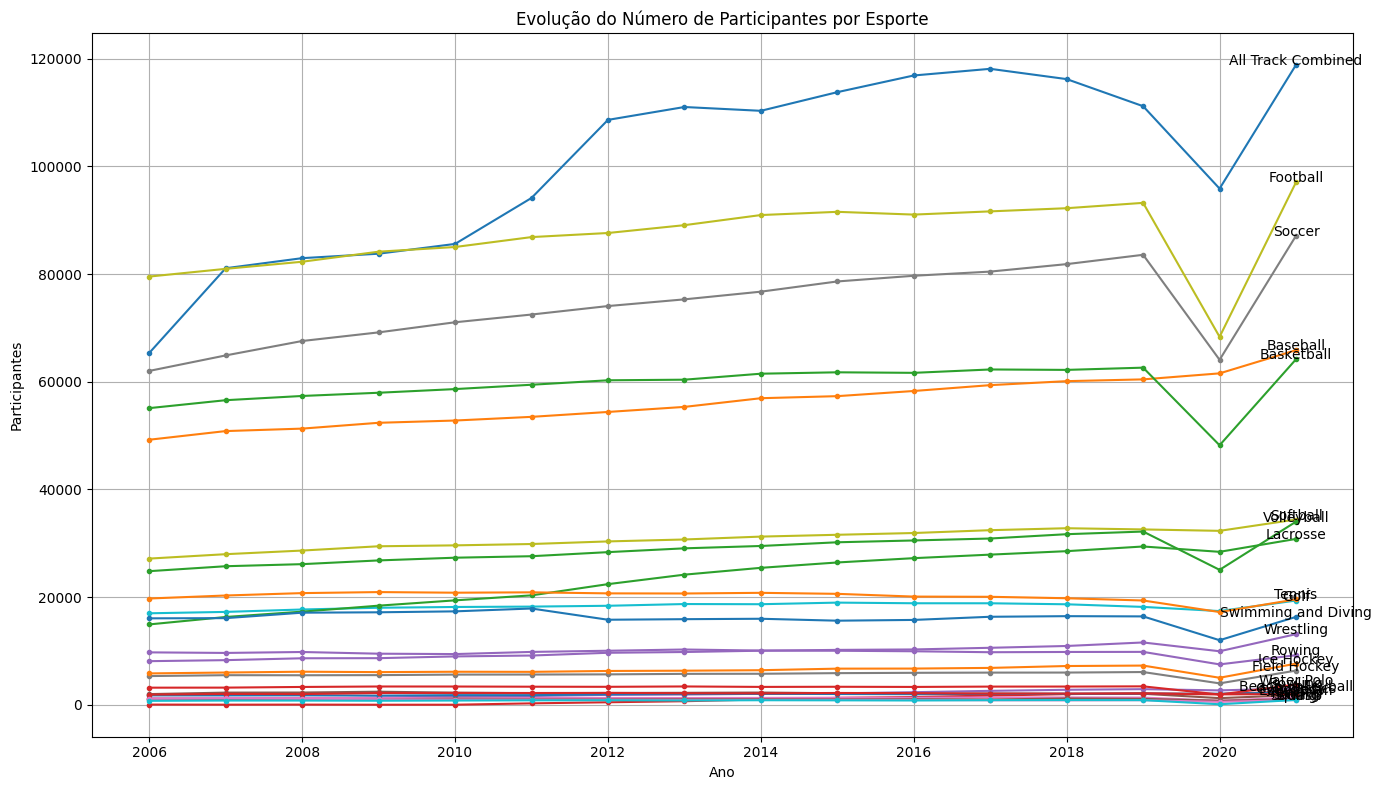

In [ ]:
linhas = data.groupby(by=['YEAR', 'Sports']).sum().reset_index()
linhas = linhas.loc[:, ['YEAR', 'Sports', 'TOTAL_PARTIC']]
linhas = linhas.sort_values(by=['Sports', 'YEAR'])

esportes = linhas.groupby('Sports')

fig, ax = plt.subplots(figsize=(14, 8))

texts = []

for sport, info in esportes:
    ax.plot(info['YEAR'], info['TOTAL_PARTIC'], marker='.', linestyle='-', label=sport)

    ultimo_participantes = info.iloc[-1]['TOTAL_PARTIC']

    texts.append(ax.text(info.iloc[-1]['YEAR'], ultimo_participantes, sport, horizontalalignment='center',))

    #ax.annotate(sport, xy=(info.iloc[-1]['YEAR'], ultimo_participantes), xytext=(10, 0),
                #textcoords='offset points', ha='left', va='baseline')

ax.set_xlabel('Ano')
ax.set_ylabel('Participantes')
ax.set_title('Evolução do Número de Participantes por Esporte')
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#adjust_text(texts, time_lim=30, arrowprops=dict(arrowstyle='-', color='black', alpha=1), ax=ax)

# Exibindo o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

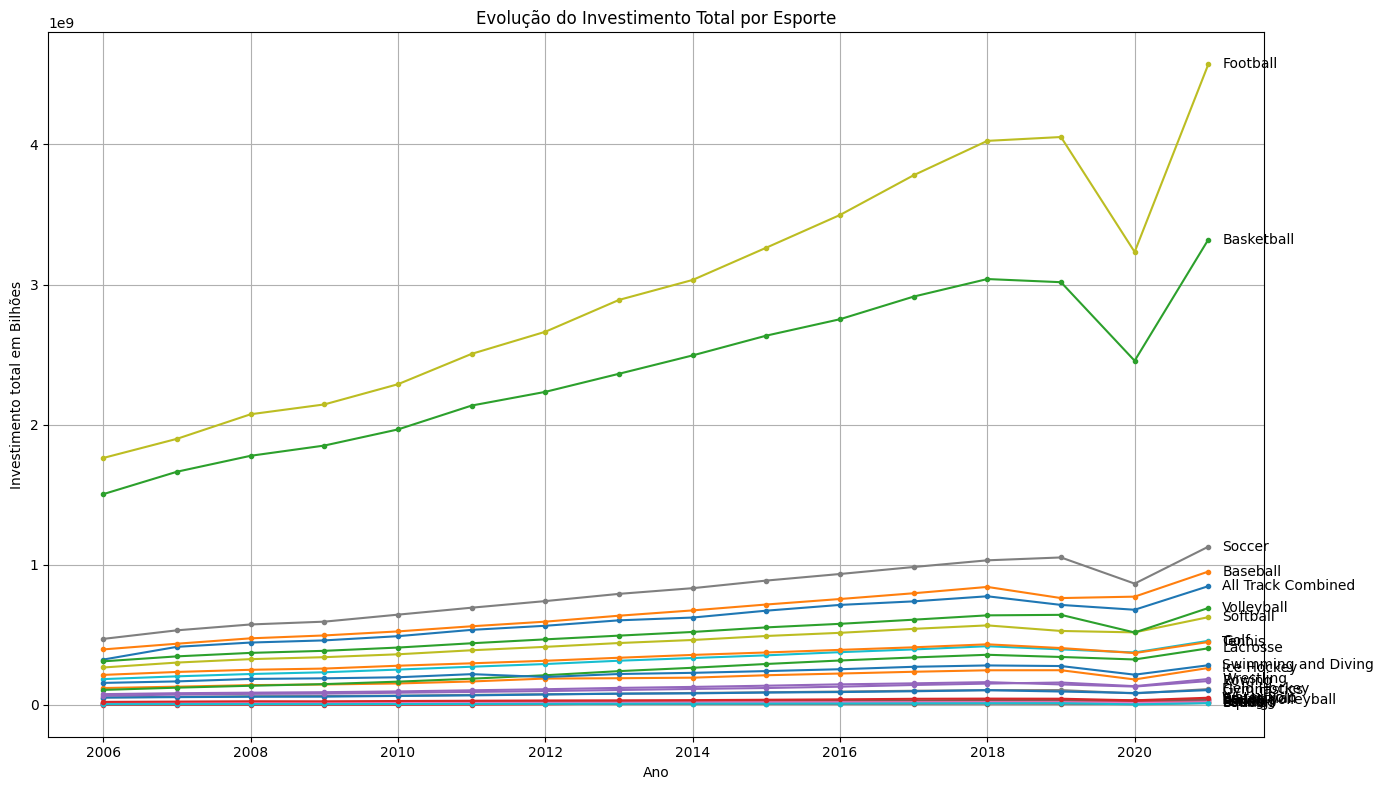

In [ ]:
linhas = data.groupby(by=['YEAR', 'Sports']).sum().reset_index()
linhas = linhas.loc[:, ['YEAR', 'Sports', 'TOTAL_EXPENSE_ALL']]
linhas = linhas.sort_values(by=['Sports', 'YEAR'])

esportes = linhas.groupby('Sports')

fig, ax = plt.subplots(figsize=(14, 8))

for sport, info in esportes:
    ax.plot(info['YEAR'], info['TOTAL_EXPENSE_ALL'], marker='.', linestyle='-', label=sport)

    ultimo_participantes = info.iloc[-1]['TOTAL_EXPENSE_ALL']
    ax.annotate(sport, xy=(info.iloc[-1]['YEAR'], ultimo_participantes), xytext=(10, 0),
                textcoords='offset points', ha='left', va='center')

ax.set_xlabel('Ano')
ax.set_ylabel('Investimento total em Bilhões')
ax.set_title('Evolução do Investimento Total por Esporte')
#ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# Exibindo o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

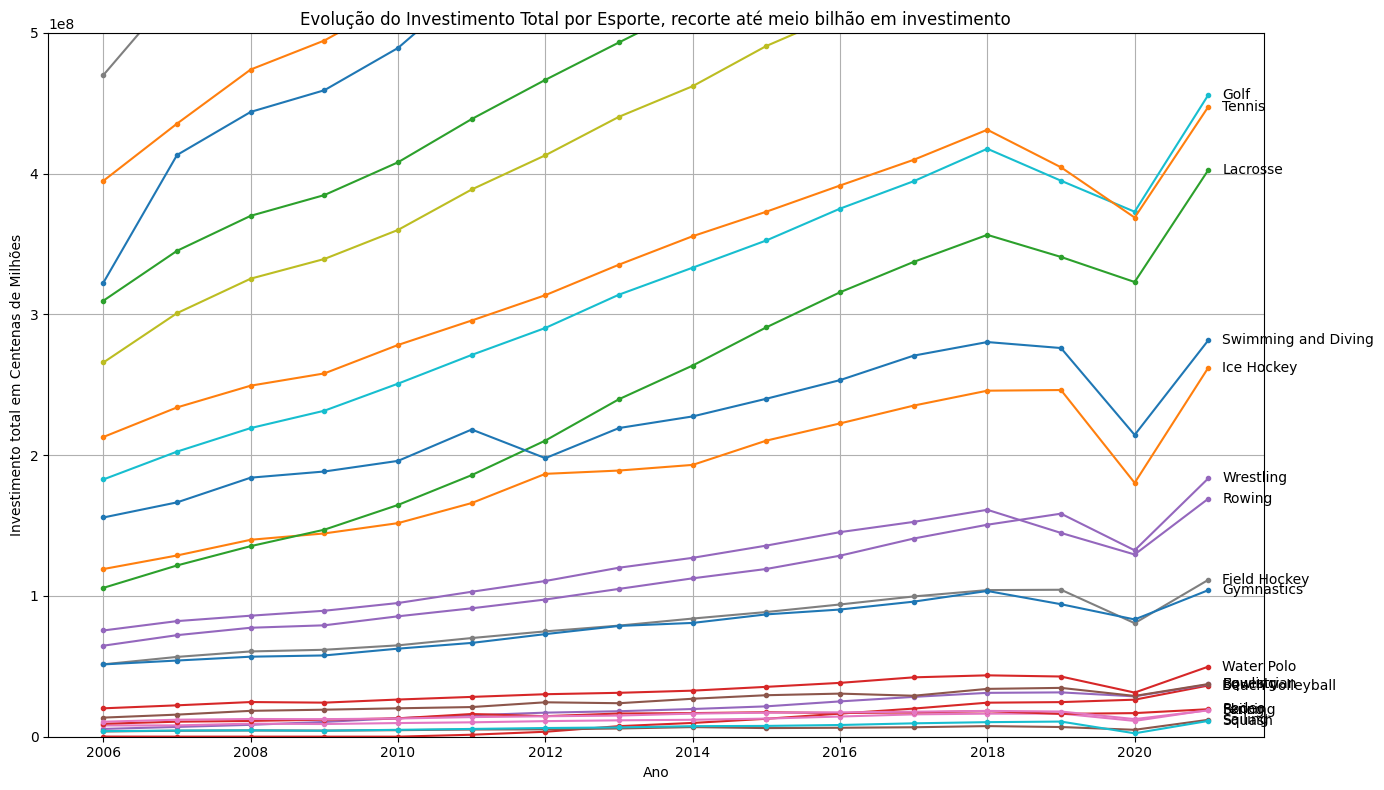

In [ ]:
linhas = data.groupby(by=['YEAR', 'Sports']).sum().reset_index()
linhas = linhas.loc[:, ['YEAR', 'Sports', 'TOTAL_EXPENSE_ALL']]
linhas = linhas.sort_values(by=['Sports', 'YEAR'])

esportes = linhas.groupby('Sports')

fig, ax = plt.subplots(figsize=(14, 8))

for sport, info in esportes:
    ax.plot(info['YEAR'], info['TOTAL_EXPENSE_ALL'], marker='.', linestyle='-', label=sport)

    ultimo_participantes = info.iloc[-1]['TOTAL_EXPENSE_ALL']
    ax.annotate(sport, xy=(info.iloc[-1]['YEAR'], ultimo_participantes), xytext=(10, 0),
                textcoords='offset points', ha='left', va='center')

ax.set_xlabel('Ano')
ax.set_ylabel('Investimento total em Centenas de Milhões')
ax.set_title('Evolução do Investimento Total por Esporte, recorte até meio bilhão em investimento')
ax.set_ylim(0, 500_000_000)
#ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# Exibindo o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

### Resultados

Observamos que na questão de número de atletas, existem várias modalidades que dividem o total de atletas, porém o atletismo é a líder nesse quesito, já que é um compilado de muitas modalidades.

Apesar disso, o gráfico de investimento mostra um cenário bem diferente e muito mais desigual.
Futebol Americano e Basquete dominam o cenário em todos os anos. O Atletismo que antes era o primeiro em número de atletas, tem cerca de 12% do investimento do Futebol Americano.

É perceptível que o número de atletas tem uma certa regularidade através dos anos, os números não aumentam muito, porém o investimento tem crescido a cada ano, o que significa que o investimento por atleta tem aumentado bastante.

Todos os valores sofreram uma queda em 2020, provavelmente em decorrência da pandemia de Covid-19.

## Intervalo de Confiança

In [ ]:
def bootstrap_mean(df, column, n=5000, size=None):
    '''
    Faz um boostrap da média da coluna escolhida. Gera amostras.

    Parâmetros
    ----------
    df: o dataframe
    column: a coluna que queremos focar
    n: número de amostras para o bootstrap
    size: tamanho de cada amostra, por padrão vira o tamanho do df.
    '''
    if size is None:
        size = len(df)
    values = np.zeros(n)
    for i in range(n):
        sample = df[column].sample(size, replace=True)
        values[i] = sample.mean()
    return values

### A liderança em popularidade do Futebol Americano pode ser explicada pelo acaso?

O boxplot que mostra os intervalos de confiança mostra que não, o intervalo de bootstrap do Futebol Americano é muito distinto dos outros esportes, ou seja, do ponto de vista estatístico, existe um claro viés que influencia no investimento do esporte.

O plot seguinte mostra a mesma relação, porém analisada sobre os investimentos em atletismo, este mostra que o atletismo está contido no intervalo de confiança, logo o acaso explica seus valores de investimento.

<Axes: >

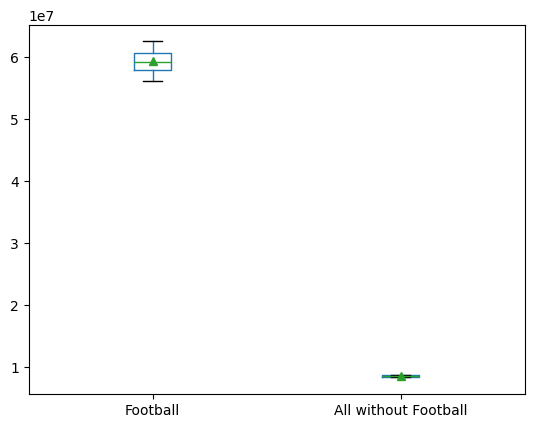

In [ ]:
football = data.loc[data["Sports"] == "Football"]
no_football = data.loc[data["Sports"] != "Football"]

football_mean = bootstrap_mean(football, "TOTAL_EXPENSE_ALL")
all_mean = bootstrap_mean(no_football, "TOTAL_EXPENSE_ALL")

to_plot = pd.DataFrame()
to_plot['Football'] = football_mean
to_plot['All without Football'] = all_mean

to_plot.boxplot(grid=False, sym='', whis=[5, 95], showmeans=True)

<Axes: >

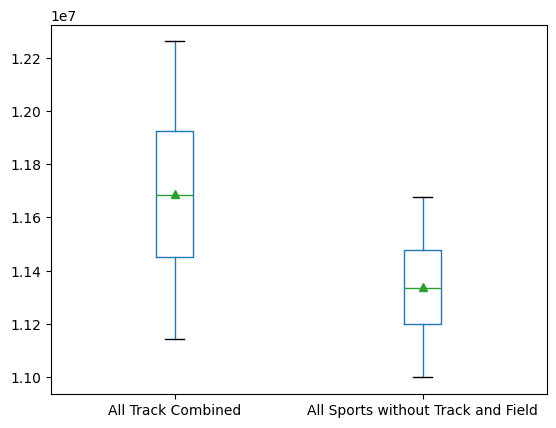

In [ ]:
atletismo = data.loc[data["Sports"] == "All Track Combined"]
all = data.loc[data["Sports"] != "All Track Combined"]

atletismo_mean = bootstrap_mean(atletismo, "TOTAL_EXPENSE_ALL")
all_mean = bootstrap_mean(all, "TOTAL_EXPENSE_ALL")

to_plot = pd.DataFrame()
to_plot['All Track Combined'] = atletismo_mean
to_plot['All Sports without Track and Field'] = all_mean

to_plot.boxplot(grid=False, sym='', whis=[5, 95], showmeans=True)

# Pergunta 2: Diferença de investimento nos esportes entre os estados norte-americanos ao longo dos anos

A desigualdade entre homens e mulheres nos esportes é um tema discutido recorrentemente. Ao propor a pergunta apresentada acima, buscamos analisar não apenas essa desigualdade de investimento nas modalidades esportivas masculinas e femininas, como também buscamos investigar se a diferença de investimento nos esportes difere de maneira significativa entre os estados americanose ao longo dos anos.

## Análise Exploratória

### Construção de estruturas básicas para implementar as análises referentes à pergunta 2

In [33]:
# Construção de um dicionário que atribui a cada esporte um código

df_sports = df[["Sports", "SPORTSCODE"]].drop_duplicates()

code_sport = {}
for index, row in df_sports.iterrows():
  if row["SPORTSCODE"] not in code_sport.keys():
    code_sport[row["SPORTSCODE"]] = row["Sports"]

myKeys = list(code_sport.keys())
myKeys.sort()
sorted_dict = {i: code_sport[i] for i in myKeys}

In [35]:
# Construção de listas com as siglas de todos os estados norte-americanos e de todos os anos com os quais estamos trabalhando

estados = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR', 'VI', 'BC']

years = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

### Análise do investimento que cada esporte recebe por estado

Nesse primeiro momento, o objetivo era analisar as diferenças de investimento que cada estado faz em cada esporte.

As duas células abaixo constroem dois dicionários que armazenam o investimento feito por cada estado em cada um dos esportes ao longo dos anos

In [36]:
# Cada chave desse dicionário é uma sigla de um estado e o valor do dicionário
# principal é um outro dicionário, cuja chave é cada ano presente na base e o valor
# são duas listas: a primeira lista apresenta o investimento do esporte que está
# na mesma posição da segunda lista

per_state_dictionary_men = {} # estado: {ano: [ [investimento], [código esporte] ]}

for index, row in df_filtered.iterrows():
    if row["state_cd"] not in per_state_dictionary_men.keys():
      per_state_dictionary_men[row["state_cd"]] = {}

    if row["YEAR"] not in per_state_dictionary_men[row["state_cd"]].keys():
      per_state_dictionary_men[row["state_cd"]][row["YEAR"]] = [[], []]

    if row["REV_MEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      per_state_dictionary_men[row["state_cd"]][row["YEAR"]][0].append(row["REV_MEN"])
      per_state_dictionary_men[row["state_cd"]][row["YEAR"]][1].append(sport_name)

In [12]:
per_state_dictionary_women = {} # estado: {ano: [ [investimento], [código esporte] ]}

for index, row in df_filtered.iterrows():
    if row["state_cd"] not in per_state_dictionary_women.keys():
      per_state_dictionary_women[row["state_cd"]] = {}

    if row["YEAR"] not in per_state_dictionary_women[row["state_cd"]].keys():
      per_state_dictionary_women[row["state_cd"]][row["YEAR"]] = [[], []]

    if row["REV_WOMEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      per_state_dictionary_women[row["state_cd"]][row["YEAR"]][0].append(row["REV_WOMEN"])
      per_state_dictionary_women[row["state_cd"]][row["YEAR"]][1].append(sport_name)

Os dois gráficos gerados a seguir apresentam a receita obtida por cada esporte (nas modalidades masculina e feminina em cada estado) ao longo de todos os anos analisados.

Text(0.5, 1.0, 'Receita que cada estado dos EUA tem por esportes masculinos')

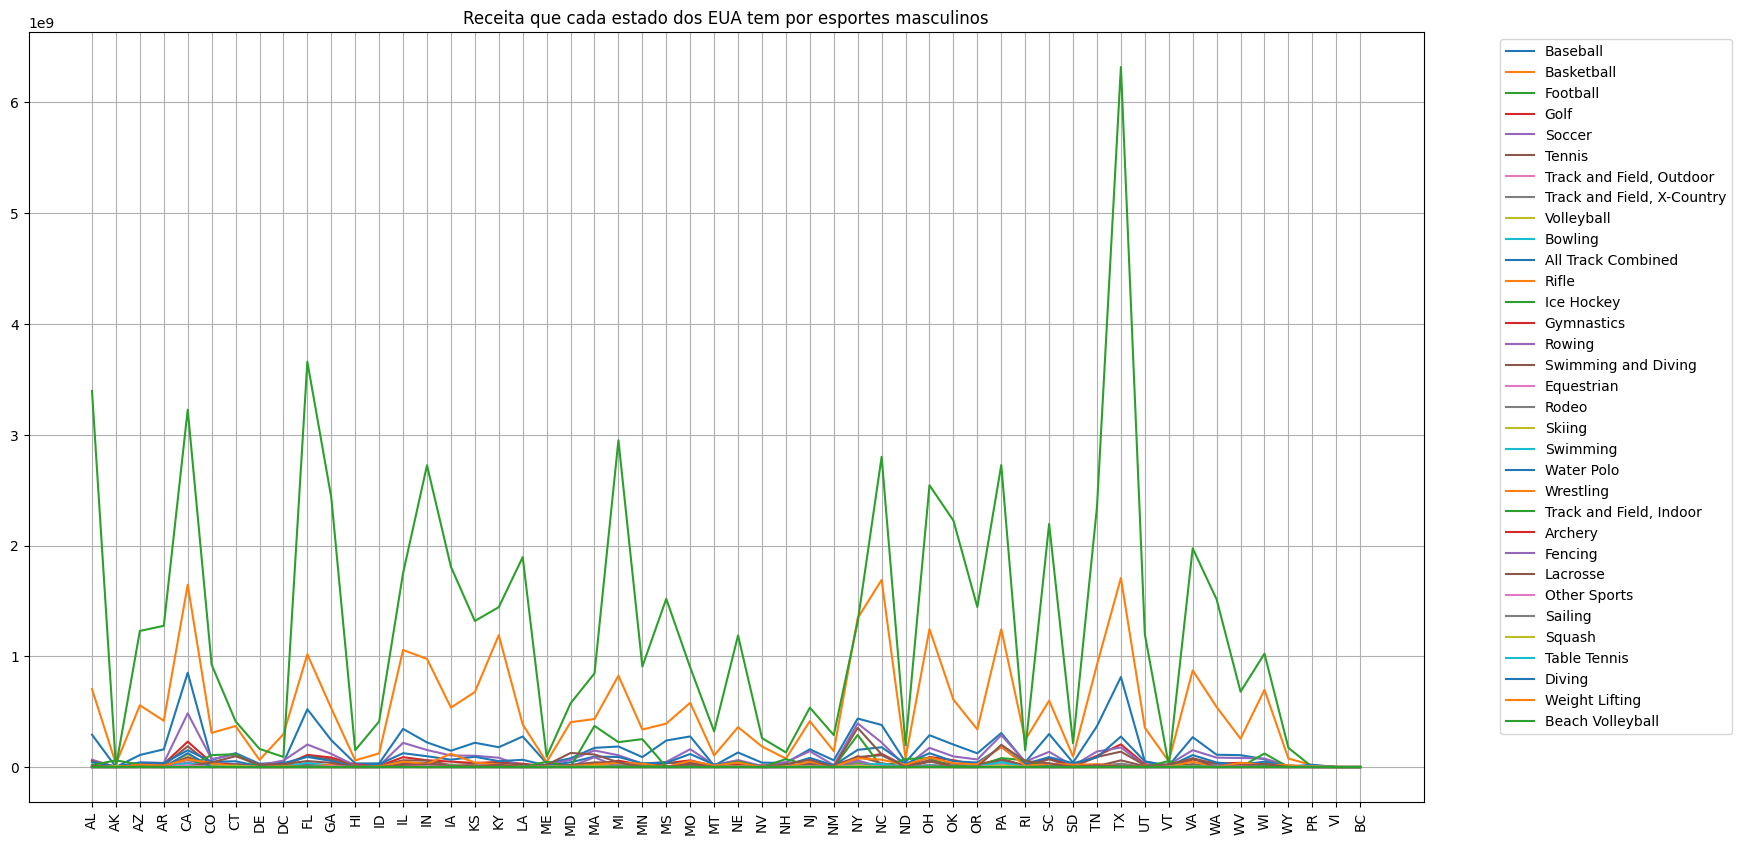

In [15]:
df_men_rev = pd.DataFrame(index=estados, columns=df["Sports"].unique())
for col in df_men_rev.columns:
    df_men_rev[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["REV_MEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      state_name = row["state_cd"]
      df_men_rev.at[state_name, sport_name] += row["REV_MEN"]

nan_value = float("NaN")
df_men_rev.replace(0, nan_value, inplace=True)

df_men_rev.dropna(how='all', axis=1, inplace=True)

df_men_rev.replace(nan_value, 0, inplace=True)

df_men_rev.plot(figsize=(18,10), grid=True)
x_values = range(len(estados))
plt.xticks(x_values, estados, rotation="vertical", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Receita que cada estado dos EUA tem por esportes masculinos")

O gráfico acima expõe que o futebol americano (representado pela cura verde mais significativa) é o esporte que mais recebe investimento (muito mais do que os demais esportes), o que era um resultado já esperado, devido ao fato deste ser um dos esportes mais populares e televisionados dos EUA. Em seguida, vemos que o basquete e o baseball (curvas laranja e azul mais significativas) também recebem muito investimento.

Testacamos que o alto investimento que o futebol americano recebe no Texas.

Text(0.5, 1.0, 'Receita que cada estado dos EUA tem por esportes femininos')

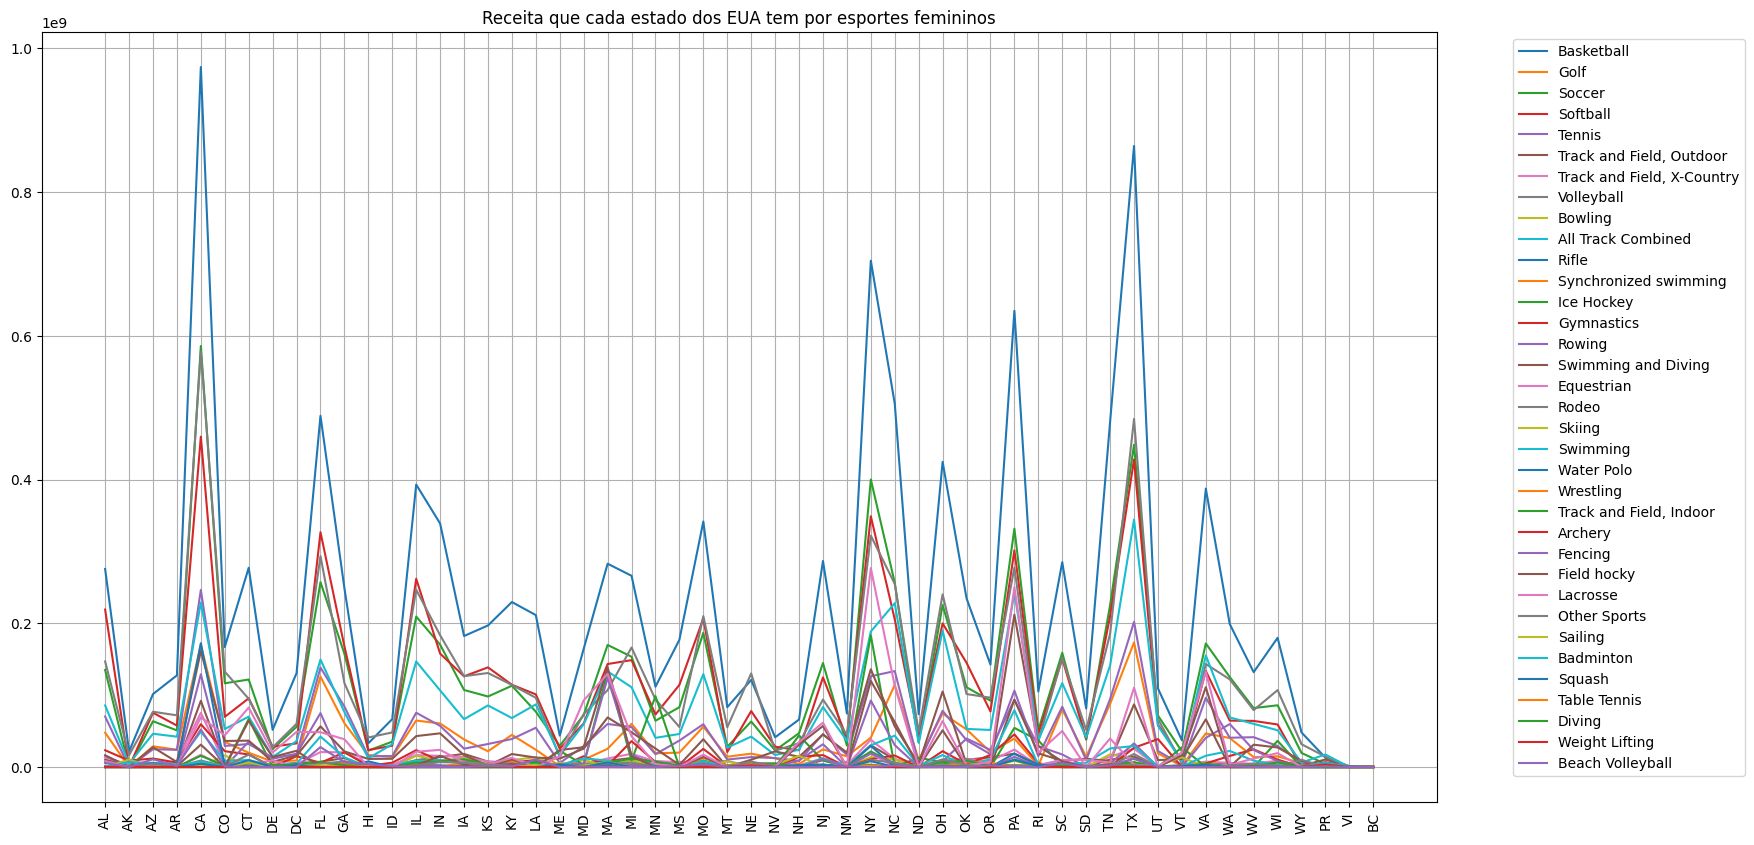

In [16]:
df_women_rev = pd.DataFrame(index=estados, columns=df["Sports"].unique())
for col in df_women_rev.columns:
    df_women_rev[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["REV_WOMEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      state_name = row["state_cd"]
      df_women_rev.at[state_name, sport_name] += row["REV_WOMEN"]

nan_value = float("NaN")
df_women_rev.replace(0, nan_value, inplace=True)

df_women_rev.dropna(how='all', axis=1, inplace=True)

df_women_rev.replace(nan_value, 0, inplace=True)

df_women_rev.plot(figsize=(18,10), grid=True)
x_values = range(len(estados))
plt.xticks(x_values, estados, rotation="vertical", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Receita que cada estado dos EUA tem por esportes femininos")

Já nesse gráfico, percebemos que o futebol americano não recebe muito investimento, devido ao fato de não ser um esporte popularmente praticado entre as mulheres. Contudo, o basquete (curva azul mais significativa) permanece recebendo alto investimento, juntamente com o futebol, o softball e o vôlei (curvas verde, vermelha e marrom, respectivamente).

Destacamos os investimentos realizados nos estados do Texas, Califórnia, Nova York e Flórida, cujas curvas de investimento de destacam muito em relação às outras.

É relevante destacar a diferença dos valores da escala do eixo 'y' em ambos os gráficos. Os valores no gráfico referente ao investimento nas modalidades masculinas é significamente maior do que os das femininas, o que sugere e reforça a realidade desigual de apoio entre homens e mulheres.

Os dois gráficos a seguir apresentam as despesas de cada esporte (nas modalidades masculina e feminina em cada estado) ao longo de todos os anos analisados em cada estado.

Text(0.5, 1.0, 'Despesas que cada estado dos EUA tem por esportes masculinos')

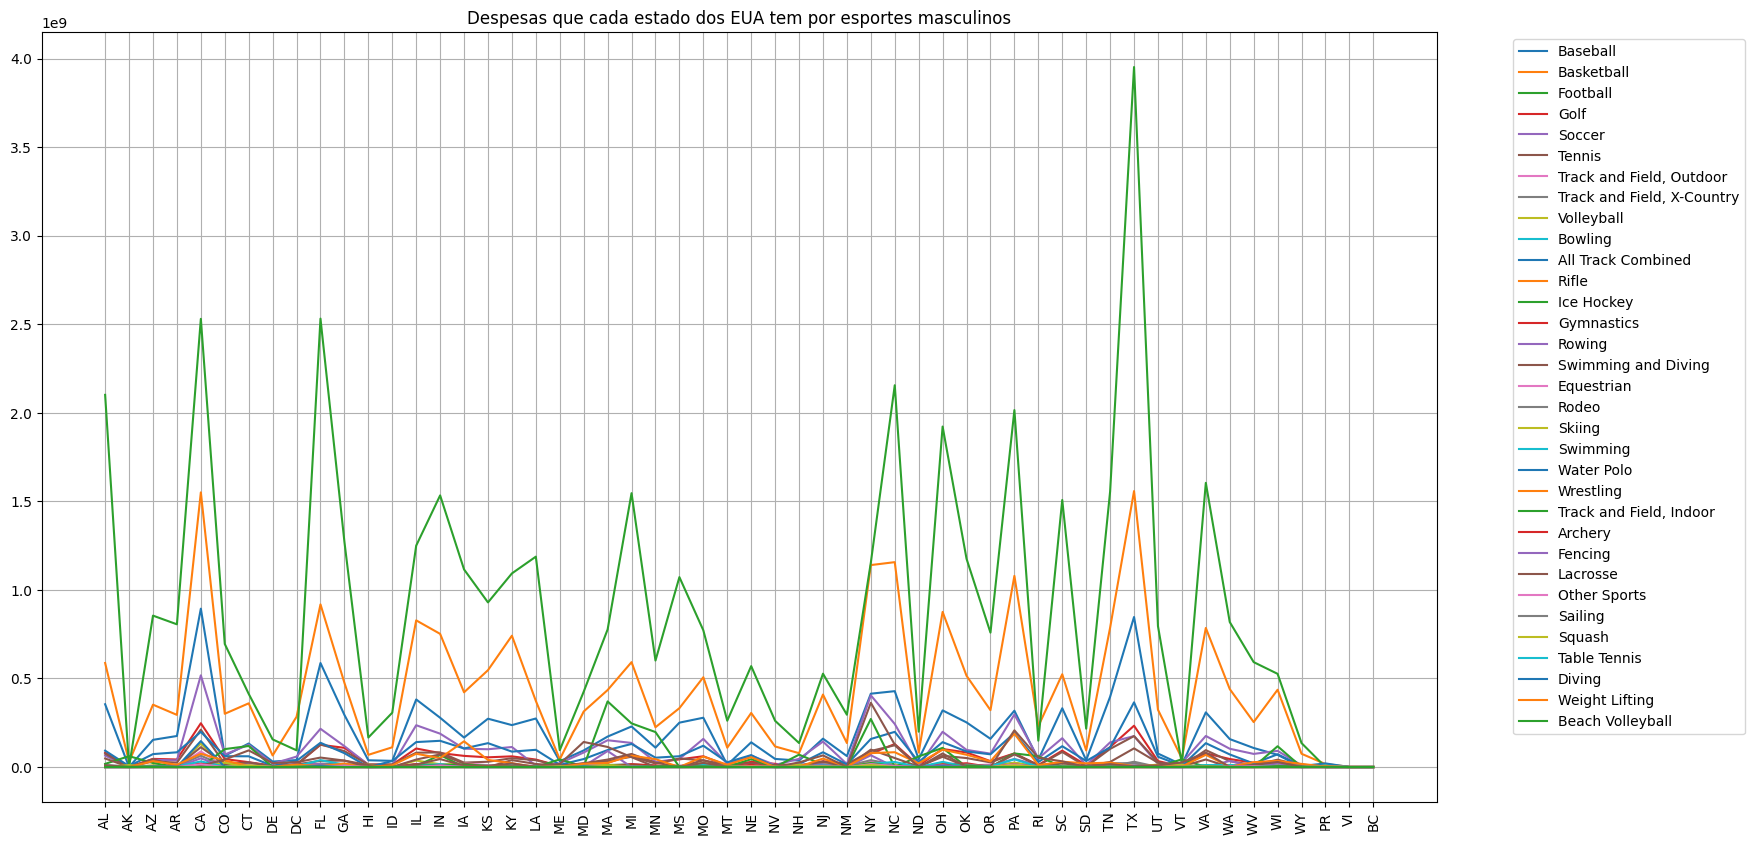

In [17]:
df_men_exp = pd.DataFrame(index=estados, columns=df["Sports"].unique())
for col in df_men_exp.columns:
    df_men_exp[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["EXP_MEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      state_name = row["state_cd"]
      df_men_exp.at[state_name, sport_name] += row["EXP_MEN"]

nan_value = float("NaN")
df_men_exp.replace(0, nan_value, inplace=True)

df_men_exp.dropna(how='all', axis=1, inplace=True)

df_men_exp.replace(nan_value, 0, inplace=True)

df_men_exp.plot(figsize=(18,10), grid=True)
x_values = range(len(estados))
plt.xticks(x_values, estados, rotation="vertical", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Despesas que cada estado dos EUA tem por esportes masculinos")

No gráfico acima, destacamos a alta despesa no futebol americano no Texas (curva verde mais significativa), que foi o que teve maior receita. Isso pode ser explicado pelo fato de que o alto investimento no esporte alta a probabilidade do melhor desempenho das equipes, o que leva à necessidade de obter equipamentos e serviços mais robustos -- que são caros -- que contribuam para melhorar a atuação e os resultados dos times.

Text(0.5, 1.0, 'Despesas que cada estado dos EUA tem por esportes femininos')

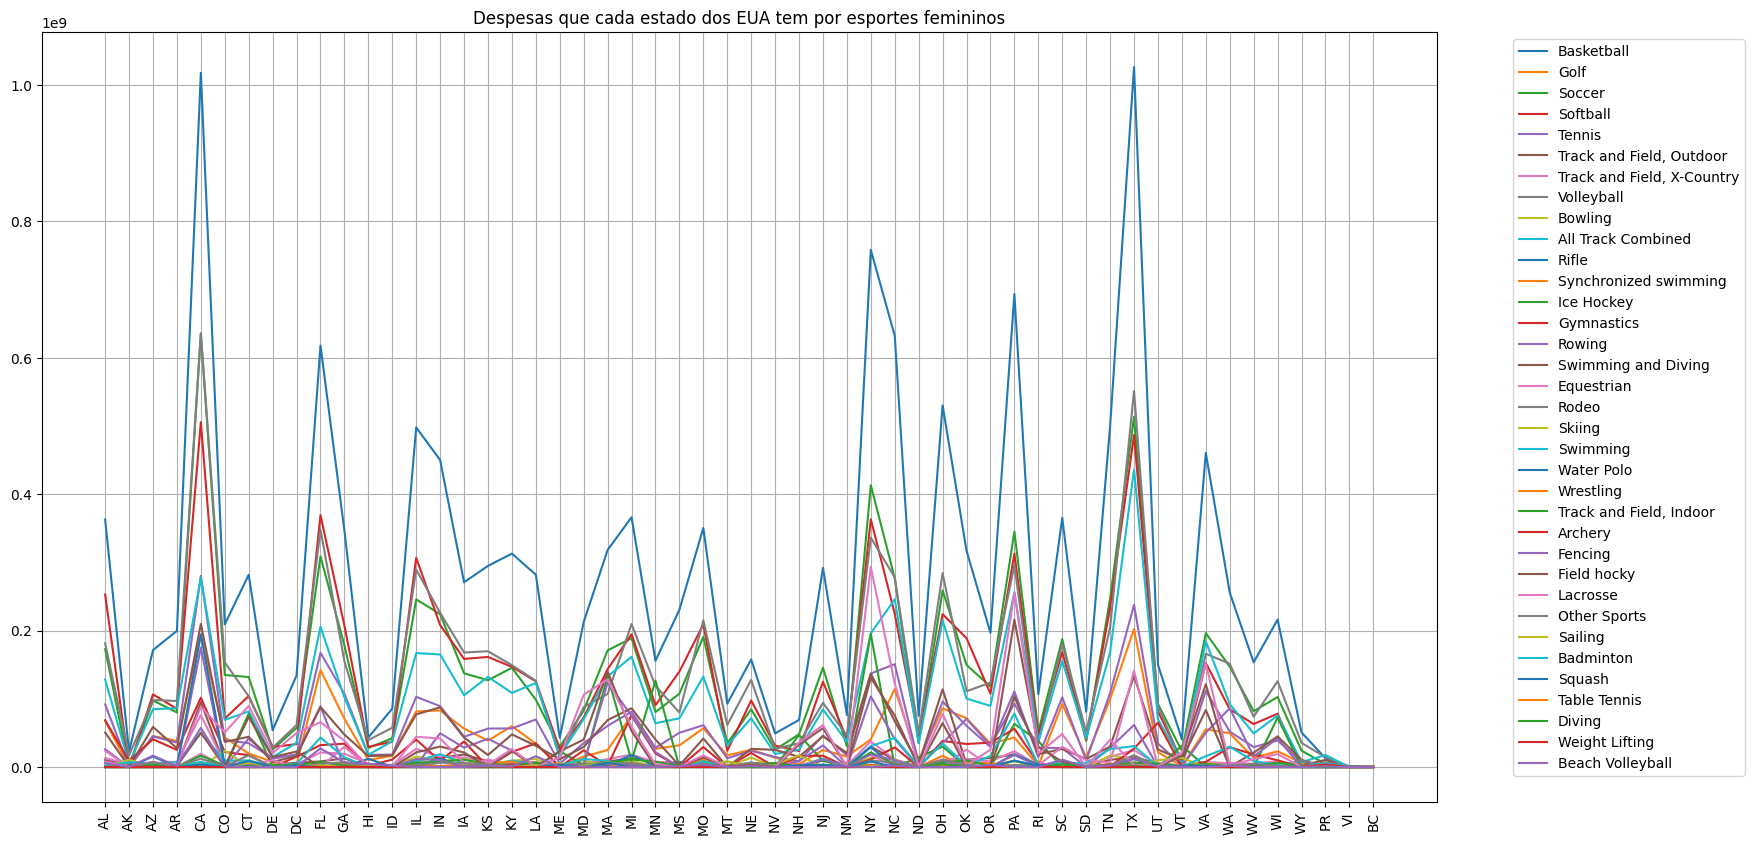

In [18]:
df_women_exp = pd.DataFrame(index=estados, columns=df["Sports"].unique())
for col in df_women_exp.columns:
    df_women_exp[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["EXP_WOMEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      state_name = row["state_cd"]
      df_women_exp.at[state_name, sport_name] += row["EXP_WOMEN"]

nan_value = float("NaN")
df_women_exp.replace(0, nan_value, inplace=True)

df_women_exp.dropna(how='all', axis=1, inplace=True)

df_women_exp.replace(nan_value, 0, inplace=True)

df_women_exp.plot(figsize=(18,10), grid=True)
x_values = range(len(estados))
plt.xticks(x_values, estados, rotation="vertical", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Despesas que cada estado dos EUA tem por esportes femininos")

No gráfico acima, destacamos a alta despesa no basquete americano no Texas e na California (curva azul mais significativa), que foi o que teve maior receita em ambos os estamos. A justificativa apresentada no gráfico anterior também é válida nesse caso.

Nos gráficos a seguir, apresentaremos as análises referentes aos lucros obtidos em cada esporte ao longo dos anos em cada estado.

Text(0.5, 1.0, 'Lucro que cada estado dos EUA tem por esportes masculinos')

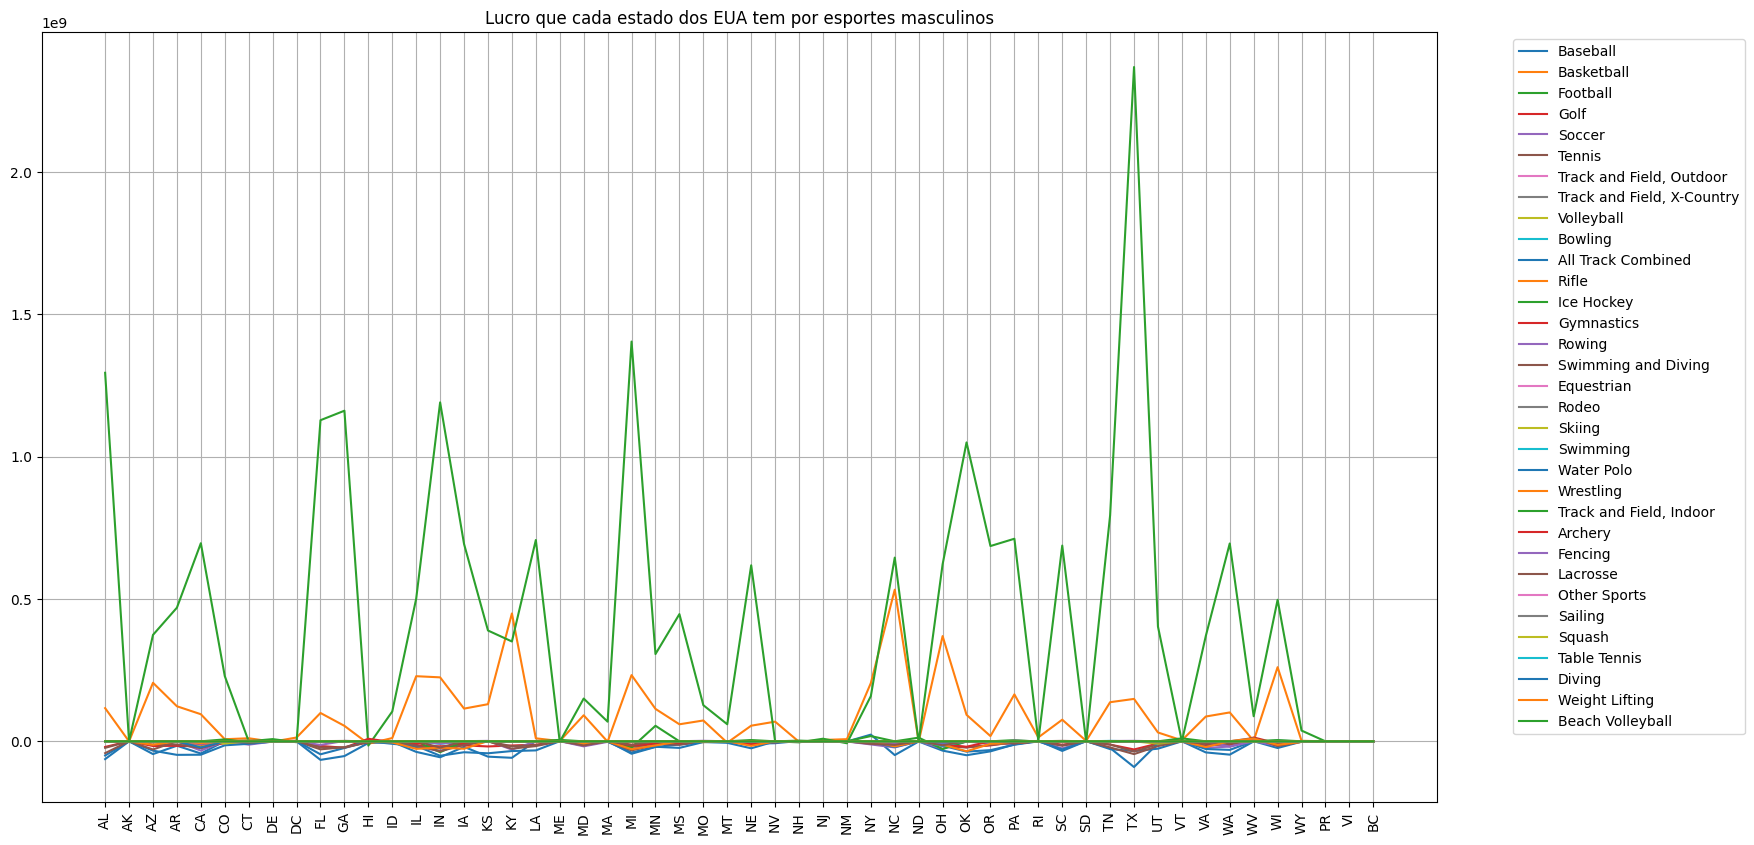

In [19]:
df_men_lucro = df_men_rev - df_men_exp

nan_value = float("NaN")
df_men_lucro.replace(0, nan_value, inplace=True)

df_men_lucro.dropna(how='all', axis=1, inplace=True)

df_men_lucro.replace(nan_value, 0, inplace=True)

df_men_lucro.plot(figsize=(18,10), grid=True)
x_values = range(len(estados))
plt.xticks(x_values, estados, rotation="vertical", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Lucro que cada estado dos EUA tem por esportes masculinos")

O gráfico acima revela que o futebol americano é o que tem mais lucro entre os esportes analisados, devido ao fato de ser o mais popular, o que leva à maior procura por eventos por parte dos indivíduos. Vale destacar que há esporte que obtiveram prejuízo ao longo dos anos, mas tal perda não foi tão drástica como nas modalidades femininas, como será apresentado a seguir.

Text(0.5, 1.0, 'Lucro que cada estado dos EUA tem por esportes femininos')

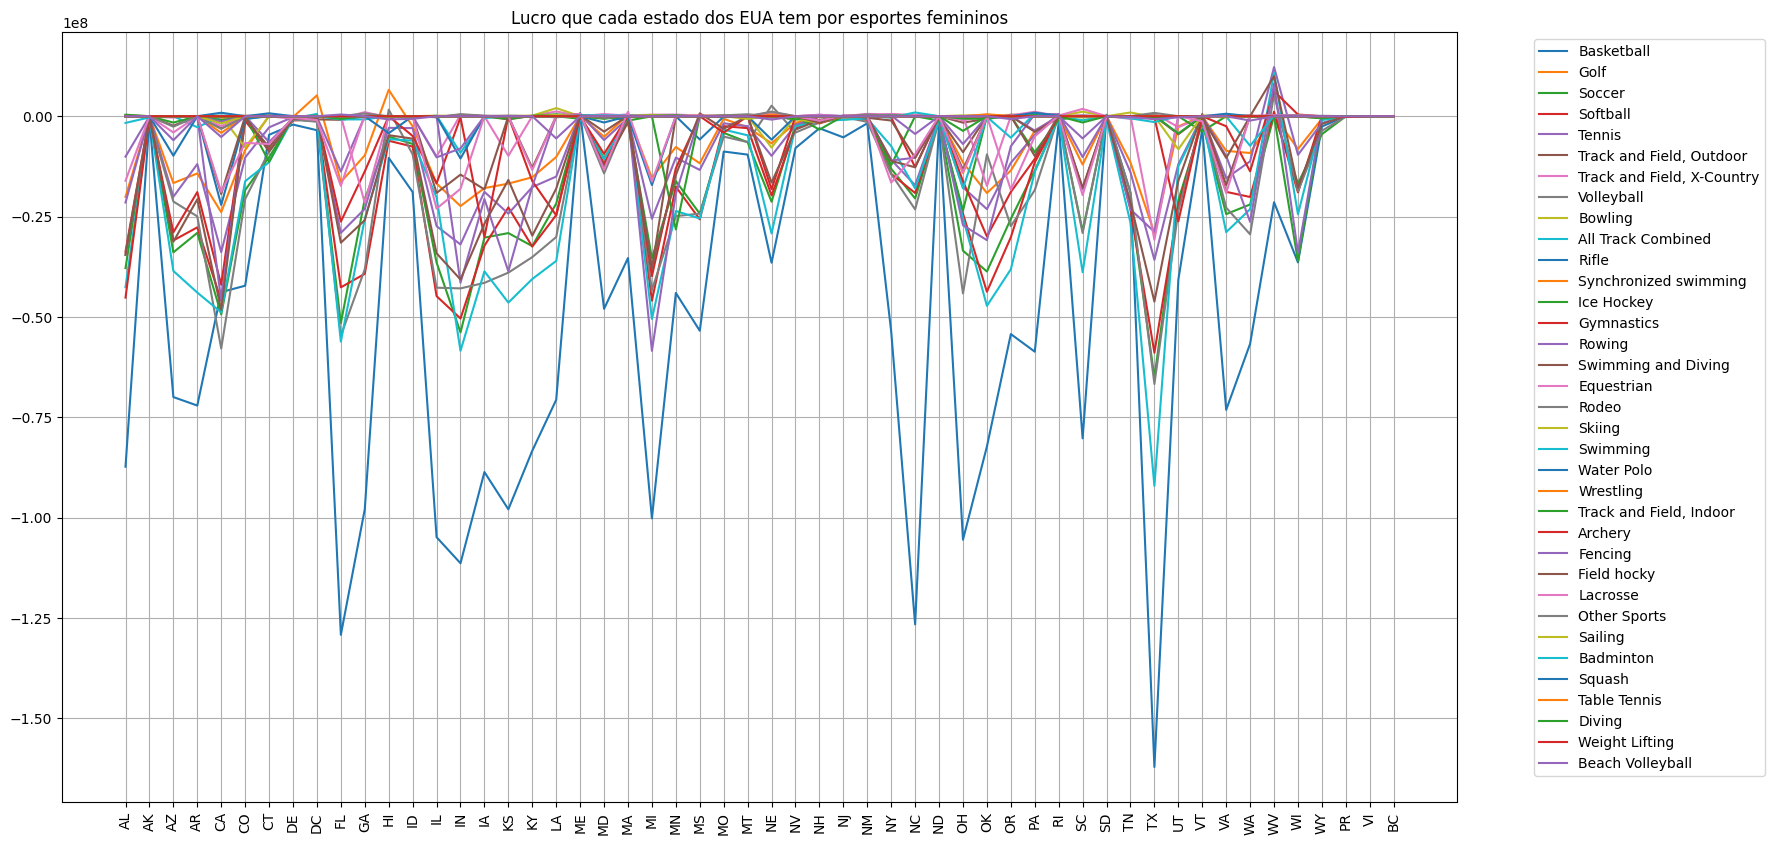

In [20]:
df_women_lucro = df_women_rev - df_women_exp

nan_value = float("NaN")
df_women_lucro.replace(0, nan_value, inplace=True)

df_women_lucro.dropna(how='all', axis=1, inplace=True)

df_women_lucro.replace(nan_value, 0, inplace=True)

df_women_lucro.plot(figsize=(18,10), grid=True)
x_values = range(len(estados))
plt.xticks(x_values, estados, rotation="vertical", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Lucro que cada estado dos EUA tem por esportes femininos")

Em contrapartida, destacamos que a maioria dos esportes femininos têm um grande prejuízo (há mais prejuízo do que lucro), o que reflete a realidade de que o baixo investimento feito aos esportes femininos não cobrem os custos para sustentar o esporte e garantir uma boa performace das atletas.

Os dois gráficos a seguir apresentam os intervalos de confiança dos lucros que cada estados têm.

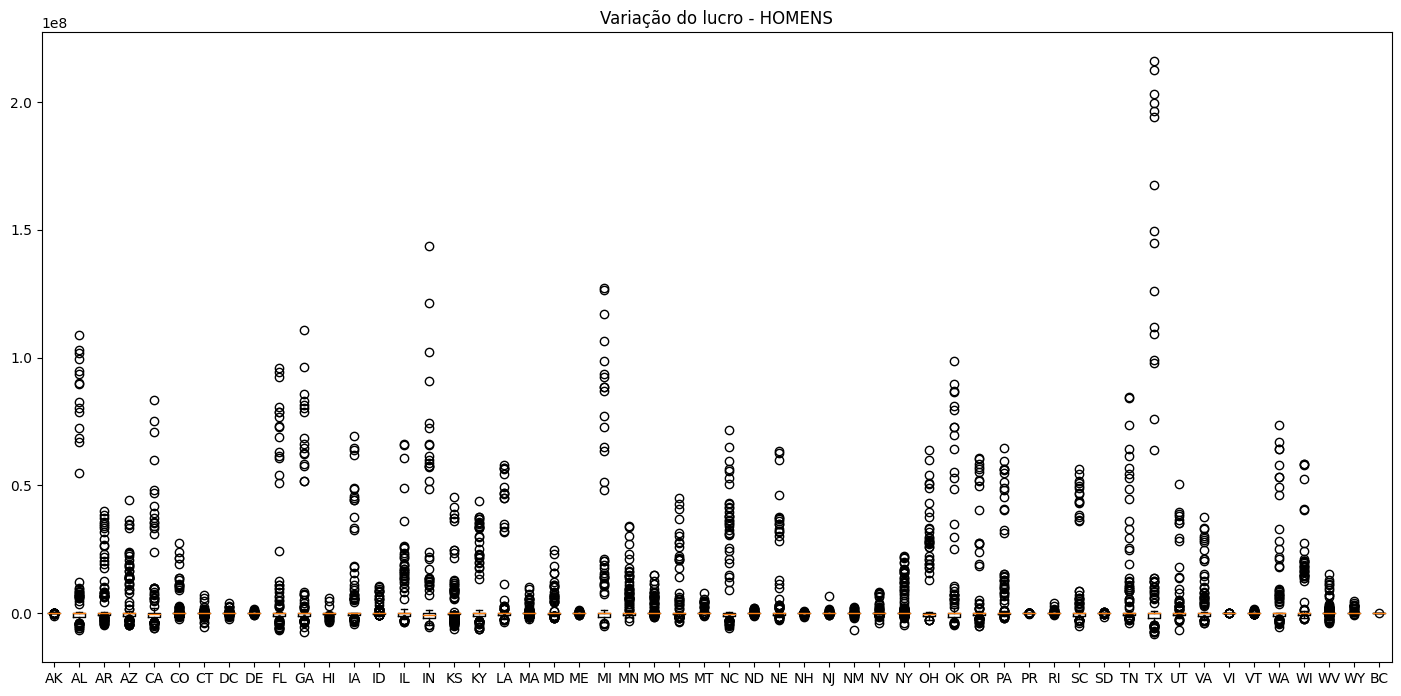

In [21]:
profit_men = {} # estado: {ano: [ [lucro], [código esporte] ]}

for index, row in df_filtered.iterrows():
    if row["state_cd"] not in profit_men.keys():
      profit_men[row["state_cd"]] = {}

    if row["YEAR"] not in profit_men[row["state_cd"]].keys():
      profit_men[row["state_cd"]][row["YEAR"]] = [[], []]

    if row["EXP_MEN"] != 0.0 or row["REV_MEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      profit_men[row["state_cd"]][row["YEAR"]][0].append(row["REV_MEN"] - row["EXP_MEN"])
      profit_men[row["state_cd"]][row["YEAR"]][1].append(sport_name)

data = []
for elem in profit_men.values():
  data_state = []
  for arrays in elem.values():
    data_state = data_state + arrays[0]
  data.append(data_state)


fig = plt.figure(figsize =(15, 7))
ax = fig.add_axes([0.06, 0.04, 0.9, 0.9])
bp = ax.boxplot(data)
ax.set_xticklabels(profit_men.keys())
plt.title("Variação do lucro - HOMENS")
plt.show()

Percebemos que, apesar dos outliers, a variação dos lucros é muito baixa, na qual predomina o lucro ser muito próximo de zero. O boxplot revela que, em todos os estados, se um esporte tem um lucro muito grande ou muito pequeno, definitivamente há um evento externo influenciando tal situação (não pode ser explicada pelo acaso).

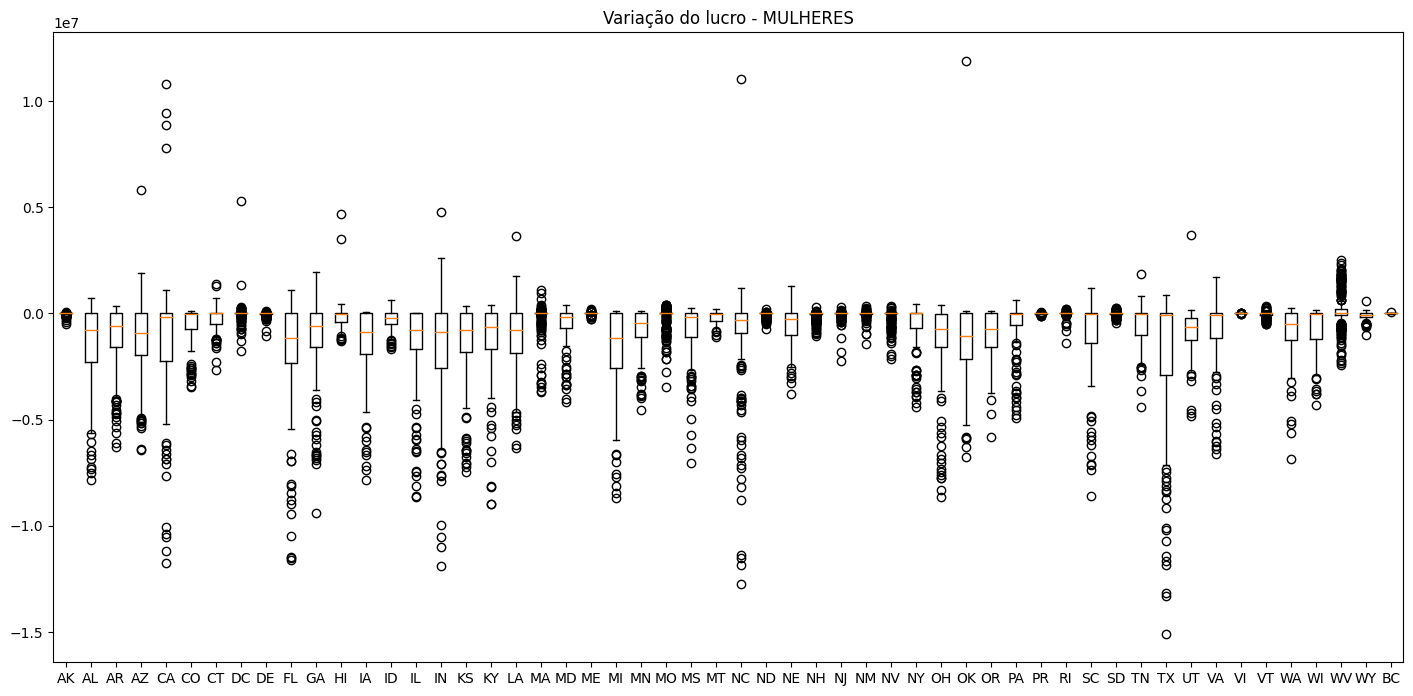

In [22]:
profit_women = {} # estado: {ano: [ [lucro], [código esporte] ]}

for index, row in df_filtered.iterrows():
    if row["state_cd"] not in profit_women.keys():
      profit_women[row["state_cd"]] = {}

    if row["YEAR"] not in profit_women[row["state_cd"]].keys():
      profit_women[row["state_cd"]][row["YEAR"]] = [[], []]

    if row["EXP_WOMEN"] != 0.0 or row["REV_WOMEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      profit_women[row["state_cd"]][row["YEAR"]][0].append(row["REV_WOMEN"] - row["EXP_WOMEN"])
      profit_women[row["state_cd"]][row["YEAR"]][1].append(sport_name)

data = []
for elem in profit_women.values():
  data_state = []
  for arrays in elem.values():
    data_state = data_state + arrays[0]
  data.append(data_state)


fig = plt.figure(figsize =(15, 7))
ax = fig.add_axes([0.06, 0.04, 0.9, 0.9])
bp = ax.boxplot(data)
ax.set_xticklabels(profit_women.keys())
plt.title("Variação do lucro - MULHERES")
plt.show()

Em contrapartida, os intervalos de confiança do lucro que cada estado obtém com os esportes femininos são mais extensos, tendendo a ser negativos -- indicam que o prejuízo pode ser explicado pelo acaso. É sugerido que lucros muito altos são causados por situações externas e não é "comum", bem como prejuízos muito altos.

### Análise do lucro de cada esporte em cada ano

Outra análise que realizamos foi referente ao lucro que cada esporte obteve ao longo dos anos. Realizamos tal análise tendo como maior objetivo investigar o impacto da Pandemia e da Crise de 2008 nos investimentos dos esportes universitários.

Text(0.5, 1.0, 'Lucro por esportes masculinos por ano')

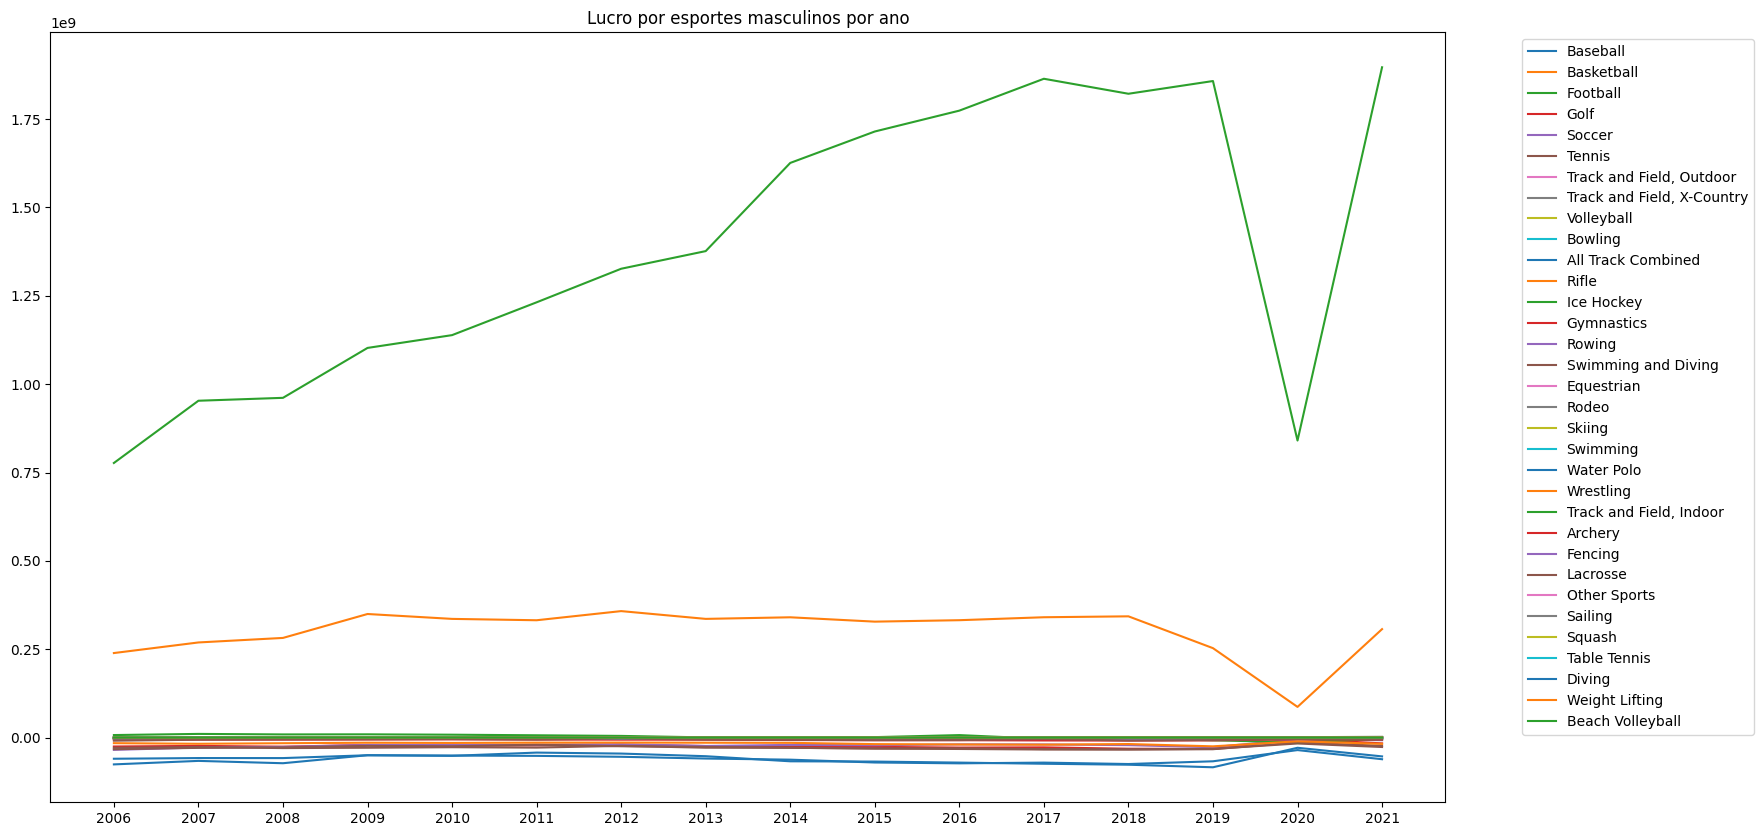

In [27]:
df_men_rev = pd.DataFrame(index=years, columns=df["Sports"].unique())
for col in df_men_rev.columns:
    df_men_rev[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["REV_MEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      year = row["YEAR"]
      df_men_rev.at[year, sport_name] += row["REV_MEN"]

nan_value = float("NaN")
df_men_rev.replace(0, nan_value, inplace=True)

df_men_rev.dropna(how='all', axis=1, inplace=True)

df_men_rev.replace(nan_value, 0, inplace=True)

df_men_exp = pd.DataFrame(index=years, columns=df["Sports"].unique())
for col in df_men_exp.columns:
    df_men_exp[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["EXP_MEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      year = row["YEAR"]
      df_men_exp.at[year, sport_name] += row["EXP_MEN"]

nan_value = float("NaN")
df_men_exp.replace(0, nan_value, inplace=True)

df_men_exp.dropna(how='all', axis=1, inplace=True)

df_men_exp.replace(nan_value, 0, inplace=True)

df_lucro = df_men_rev - df_men_exp

df_lucro.plot(figsize=(18,10))
x_values = range(len(years))
plt.xticks(years,fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Lucro por esportes masculinos por ano")

Conforme esperávamos, o ano de 2020 apresentou uma queda nos lucros dos esportes, principalment e do futebol americano (curva verde) e do basquete (curva laranja). Nos demais esportes, não é possível verificar se o lucro diminuiu, devido à constância ao longo dos anos. Nos esportes que não obtiveram esse alto prejuízo nesse período, tal realidade pode ser explicada pelo fato de que, com o lockdown que o passou teve, os gastos que não eram fixos não eram realizados, o que levou ao menor custo nesse ano.

Por outro lado, em 2008, devido à forte crise imobiliária e financeira que os EUA sofreu, não houve impacto significativo no lucro dos esportes universitários.

Text(0.5, 1.0, 'Lucro por esportes femininos por ano')

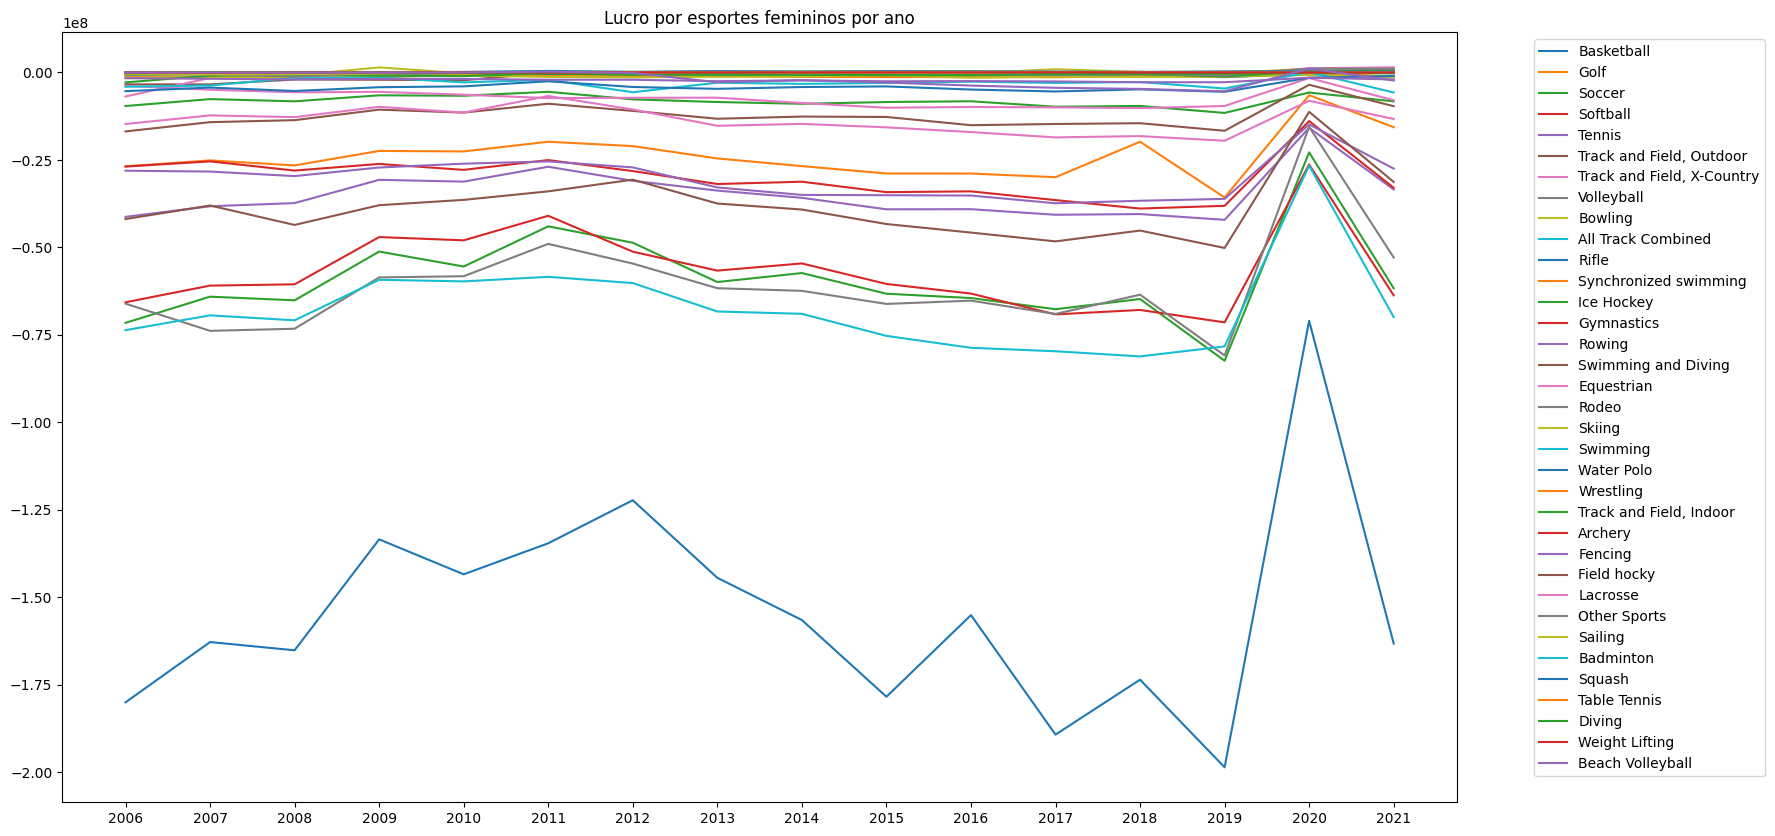

In [28]:
df_women_rev = pd.DataFrame(index=years, columns=df["Sports"].unique())
for col in df_women_rev.columns:
    df_women_rev[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["REV_WOMEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      year = row["YEAR"]
      df_women_rev.at[year, sport_name] += row["REV_WOMEN"]

nan_value = float("NaN")
df_women_rev.replace(0, nan_value, inplace=True)

df_women_rev.dropna(how='all', axis=1, inplace=True)

df_women_rev.replace(nan_value, 0, inplace=True)

df_women_exp = pd.DataFrame(index=years, columns=df["Sports"].unique())
for col in df_women_exp.columns:
    df_women_exp[col].values[:] = 0

for index, row in df_filtered.iterrows():
    if row["EXP_WOMEN"] != 0.0:
      sport_name = sorted_dict[row["SPORTSCODE"]]
      year = row["YEAR"]
      df_women_exp.at[year, sport_name] += row["EXP_WOMEN"]

nan_value = float("NaN")
df_women_exp.replace(0, nan_value, inplace=True)

df_women_exp.dropna(how='all', axis=1, inplace=True)

df_women_exp.replace(nan_value, 0, inplace=True)

df_lucro = df_women_rev - df_women_exp

df_lucro.plot(figsize=(18,10))
x_values = range(len(years))
plt.xticks(years,fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Lucro por esportes femininos por ano")

Assim como no gráfico referente ao lucro dos esportes por estado, o prejuízo predomina nos esportes femininos, reforçando que o baixo investimento no esporte feminino perdura ao longo dos anos.

Contudo, o gráfico apresentado acima revela que, em 2020, apesar de a maioria dos esportes terem tido prejuízo, esse prejuízo foi menor em comparação aos anos anteriores, o que foi de encontro com o que esperávamos.

## Classificação

Nessa análise apresentada a seguir, tivemos o objetivo de analisar se é possível, dado o número de participantes no esporte, o lucro desse esporte e qual esporte é, classificar a qual estado se refere.

Realizamos essa análise somente sobre os estados da Califórnia, do Texas, de Nova York e da Flórida. Tomamos essa decisão de projeto, pois, inicialmente, ao tentar realizar a classificação proposta anteriormente sobre todos os estados, obtivemos um resultado muito ruim, com o R2 negativo. Portanto, decidimos fazer tal análise apenas com esses 4 estados citados, que foram os que apresentaram curvas mais significativas em todas as análises exploratórias realizadas anteriormente.

(-2.0, 9.0)

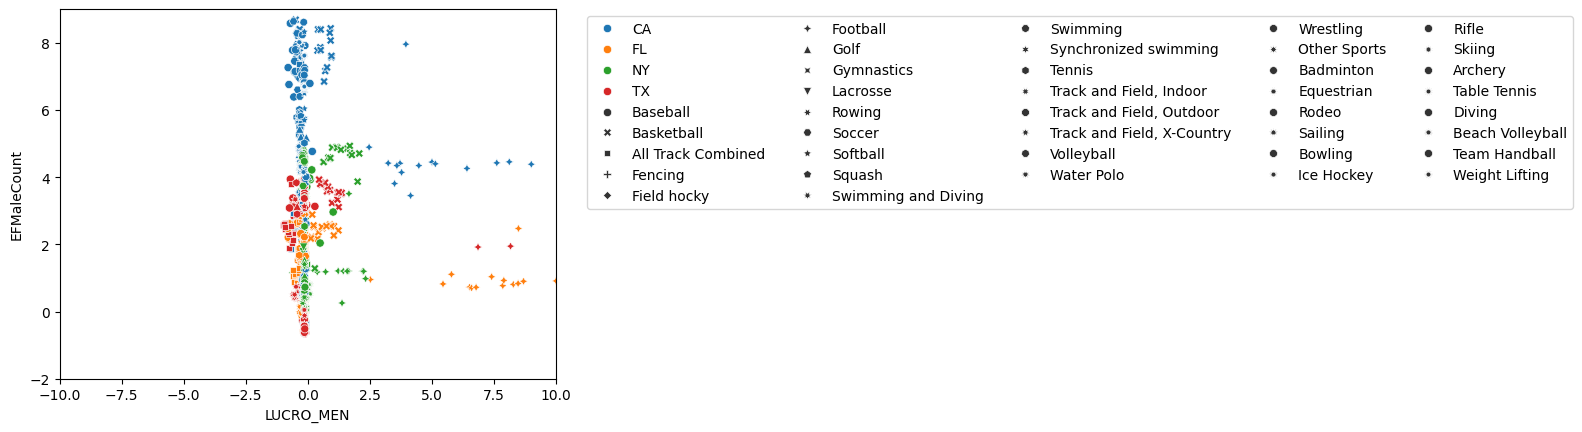

In [23]:
estados_dict = {}
i = 0

for estado in estados:
  estados_dict[estado] = i
  i += 1

znormed = df_filtered[['LUCRO_MEN', 'EFMaleCount']].copy()
znormed = (znormed - znormed.mean()) / znormed.std(ddof=1)
znormed["states"] = df_filtered['state_cd']
znormed["sport"] = df_filtered['SPORTSCODE']

sports_list = []

df_aux1 = znormed.loc[(znormed['states'] == 'TX') | (znormed['states'] == 'CA') | (znormed['states'] == 'NY') | (znormed['states'] == 'FL')]

for index, row in df_aux1.iterrows():
  sports_list.append(sorted_dict[row.loc['sport']])

X = df_aux1["LUCRO_MEN"].values
y = df_aux1["EFMaleCount"].values

sns.scatterplot(data=df_aux1, x='LUCRO_MEN', y='EFMaleCount', hue=df_aux1['states'], palette="tab10", style=sports_list)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=5)
plt.xlim(-10, 10)
plt.ylim(-2, 9)

No gráfico acima, referente aos esportes masculinos, analisamos a relação entre o lucro que um esporte tem e o número de participantes da modalidade referente. Fica evidente que o lucro nos esportes masculinos se concentram perto de zero, tendo uma variação muito baixa.

Percebemos também que, na Califórnia, a participação é maior do que nos outros estados, formando um cluster mais bem definido, enquanto, nos outros estados, as participações em cada esporte se sobrepõe, sem poder inferir conclusões que destaquem características quanto ao investimento em cada estado.

In [29]:
from sklearn.neighbors import KNeighborsClassifier

y_l = []

for e in df_aux1['states']:
  y_l.append(estados_dict[e])

y = pd.DataFrame(y_l, columns=['States'])
X = df_aux1[['EFMaleCount', 'LUCRO_MEN', 'sport']]

# Separando dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)

# Treino
kf = KFold(n_splits=5) # KFold: faz a permutação, para garantir que os dados do teste não são enviesados
accuracy_iter2 = []

for train_index, val_index in kf.split(X_train, y_train):
    X_tt = X_train.iloc[train_index]
    y_tt = y_train.iloc[train_index]
    X_v = X_train.iloc[val_index]
    y_v = y_train.iloc[val_index]

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_tt, y_tt)
    y_pred = knn.predict(X_v)

    accuracy_iter2.append(accuracy_score(y_v, y_pred))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

data_iter = []
data_iter.append(accuracy_iter2)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

Accuracy: 0.8415094339622642


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


O código acima implementa a classificação por KNN, usando k = 5 (usamos esse número de vizinhos pois foi o que deu um melhor resultado). Analisamos o valor da acurária que foi obtido (igual a 0.8415). A sobreposição dos pontos, principalmente dos estados do Texas, da Flórida e de Nova York, são os principais contribuintes que impediram que a classificação fosse melhor do que isso.

(-2.0, 9.0)

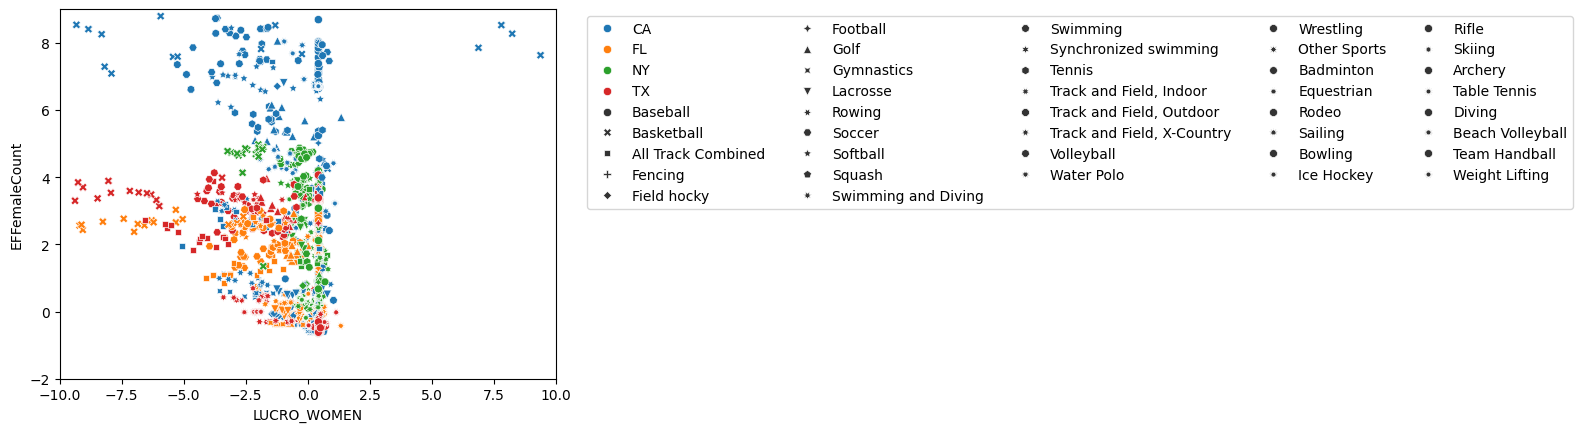

In [30]:
estados_dict = {}
i = 0

for estado in estados:
  estados_dict[estado] = i
  i += 1

znormed = df_filtered[['LUCRO_WOMEN', 'EFFemaleCount']].copy()
znormed = (znormed - znormed.mean()) / znormed.std(ddof=1)
znormed["states"] = df_filtered['state_cd']
znormed["sport"] = df_filtered['SPORTSCODE']
df_aux1 = znormed.loc[(znormed['states'] == 'TX') | (znormed['states'] == 'CA') | (znormed['states'] == 'NY') | (znormed['states'] == 'FL')]

X = df_aux1["LUCRO_WOMEN"].values
y = df_aux1["EFFemaleCount"].values

sports_list = []

for index, row in df_aux1.iterrows():
  sports_list.append(sorted_dict[row.loc['sport']])

sns.scatterplot(data=df_aux1, x='LUCRO_WOMEN', y='EFFemaleCount', hue=df_aux1['states'], palette="tab10", style=sports_list)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=5)
plt.xlim(-10, 10)
plt.ylim(-2, 9)

O gráfico apresentado acima apresenta mostra a relação entre o lucro que cada esporte tem e o número de mulheres participantes. Percebemos uma grande concentração quando o lucro é zero, mas que, ainda sim, há uma grande variação.

Além disso, percebemos que, na Califórnia, há mais mulheres participando dos esportes do que nos outros estado, mesmo quando o prejuízo é muito alto, formando um cluster melhor delimitado. Já nos outros estados, os clusters se sobrepõe de maneira significativa.

É revelado que Nova York é o estado (dentre os 4 apresentados) que apresenta menor prejuízo, mas tem participação muito semelhante aos esportes da Flórida e do Texas.

In [32]:
y_l = []

for e in df_aux1['states']:
  y_l.append(estados_dict[e])

y = pd.DataFrame(y_l, columns=['States'])
X = df_aux1[['EFFemaleCount', 'LUCRO_WOMEN', 'sport']]

# Separando dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)

# Treino
kf = KFold(n_splits=7) # KFold: faz a permutação, para garantir que os dados do teste não são enviesados
accuracy_iter = []

for train_index, val_index in kf.split(X_train, y_train):
    X_tt = X_train.iloc[train_index]
    y_tt = y_train.iloc[train_index]
    X_v = X_train.iloc[val_index]
    y_v = y_train.iloc[val_index]

    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(X_tt, y_tt)
    y_pred = knn.predict(X_v)

    accuracy_iter.append(accuracy_score(y_v, y_pred))

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

data_iter.append(accuracy_iter)

Accuracy: 0.7584905660377359


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

No código acima é implementado o algoritmo de classificação por KNN. Escolhemos k = 7, pois, durante o desenvolvimento dessa tarefa, a classificação usando esse número de vizinhos foi o que gerou o melhor resultado (que é apresentado acima).

Para realizar a classificação, realizamos KFold, para realizar um treinamento mais eficiente e impedir que houvesse algum "viés" no aprendizado. Além disso, para garantir tal objetivo, também implementamos a validação cruzada.

A métrica acurácia foi calculada e apresentada (é igual a 0.766). Percebemos que essa métrica foi menor do que a classificação realizada com os esportes masculinos. Isso pode ser explicado pelo fato do lucro nos exportes femininos variarem mais do que nos masculinos, o que dificulta no processo de classificação.